# **0. Setup**

In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.6 MB/s eta 0:00:00


In [2]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.1 MB/s eta 0:00:00


In [21]:
# Core & Warnings
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import pandas as pd
from datetime import datetime

# Visualization & Styling
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
from cycler import cycler
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import (
    LabelEncoder, OrdinalEncoder, OneHotEncoder,
    StandardScaler, RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

# Model Selection & Optimization
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_predict,
    cross_val_score, StratifiedKFold
)
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Classifiers
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier,
    SGDClassifier, PassiveAggressiveClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier,
    StackingClassifier
)
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics & Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve,
    classification_report, precision_recall_fscore_support
)
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV

# Statistics
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import mcnemar

# Unsupervised Learning / Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Utilities
from sklearn.base import BaseEstimator, TransformerMixin, clone

# Explainability
import shap

In [4]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [5]:
!wget -q -O Poppins-Regular.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Regular.ttf
!wget -q -O Poppins-Bold.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Bold.ttf

import matplotlib as mpl
import matplotlib.font_manager as fm

fm.fontManager.addfont("Poppins-Regular.ttf")
fm.fontManager.addfont("Poppins-Bold.ttf")

mpl.rcParams['font.family'] = "Poppins"

In [26]:
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlecolor'] = '#808080'
mpl.rcParams['axes.labelcolor'] = '#808080'
mpl.rcParams['xtick.color'] = '#808080'
mpl.rcParams['ytick.color'] = '#808080'
mpl.rcParams['axes.edgecolor'] = '#808080'
mpl.rcParams['legend.labelcolor'] = '#808080'

palette = ["#219dd7",  "#CCCCCC", "#ea4c89", "#6f7278", "#e0131a"]
mpl.rcParams['axes.prop_cycle'] = cycler(color=palette)
sns.set_palette(palette)
cmap = LinearSegmentedColormap.from_list("merah_putih", ["#BFBFBF",  "#B30000"])

# **1. Load & Prepare Data**

## **Load Data**

In [80]:
# Load data, duplicate for plotting, and preview first 3 rows
df = pd.read_excel('Improving Employee Retention by Predicting Employee Attrition Using Machine Learning.xlsx')
df_plot = df.copy()
display(df.head(3))

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,NomorHP,Email,TingkatPendidikan,PernahBekerja,IkutProgramLOP,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign
0,spiritedPorpoise3,111065,Belum_menikah,Pria,Outsource,Software Engineer (Back End),Freshgraduate_program,Sangat_bagus,Jakarta Timur,Employee_Referral,4,4.0,0.0,0.0,9.0,+6282232522xxx,spiritedPorpoise3135@yahoo.com,Magister,1,1.0,masih_bekerja,1972-07-01,2011-01-10,2016-2-15,-
1,jealousGelding2,106080,Belum_menikah,Pria,FullTime,Data Analyst,Freshgraduate_program,Sangat_kurang,Jakarta Utara,Website,4,4.0,4.0,0.0,3.0,+6281270745xxx,jealousGelding2239@yahoo.com,Sarjana,1,1.0,toxic_culture,1984-04-26,2014-01-06,2020-1-17,2018-6-16
2,pluckyMuesli3,106452,Menikah,Pria,FullTime,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Timur,Indeed,4,3.0,0.0,0.0,11.0,+6281346215xxx,pluckyMuesli3961@icloud.com,Magister,1,1.0,jam_kerja,1974-01-07,2011-01-10,2016-01-10,2014-9-24


## **Feature Engineering**

In [81]:
# Convert dates
date_cols = ['TanggalLahir', 'TanggalHiring', 'TanggalPenilaianKaryawan']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Create target
df['target'] = (df['AlasanResign'] != 'masih_bekerja').astype(int)

# Handle missing values
df['SkorSurveyEngagement'] = df['SkorSurveyEngagement'].fillna(df['SkorSurveyEngagement'].median())
df['SkorKepuasanPegawai'] = df['SkorKepuasanPegawai'].fillna(df['SkorKepuasanPegawai'].median())
df['JumlahKeikutsertaanProjek'] = df['JumlahKeikutsertaanProjek'].fillna(0)
df['JumlahKeterlambatanSebulanTerakhir'] = df['JumlahKeterlambatanSebulanTerakhir'].fillna(0)
df['JumlahKetidakhadiran'] = df['JumlahKetidakhadiran'].fillna(0)

# Basic time features
df['masa_kerja_hingga_sekarang'] = (datetime.now() - df['TanggalHiring']).dt.days / 365
df['umur_saat_hiring'] = (df['TanggalHiring'] - df['TanggalLahir']).dt.days / 365
df['umur_sekarang'] = (datetime.now() - df['TanggalLahir']).dt.days / 365
df['hari_sejak_penilaian'] = (datetime.now() - df['TanggalPenilaianKaryawan']).dt.days
df['bulan_sejak_penilaian'] = df['hari_sejak_penilaian'] / 30

# ENHANCED FEATURE ENGINEERING

# 1. ADVANCED TIME-BASED FEATURES
df['bulan_hiring'] = df['TanggalHiring'].dt.month
df['quarter_hiring'] = df['TanggalHiring'].dt.quarter
df['tahun_hiring'] = df['TanggalHiring'].dt.year
df['day_of_week_hiring'] = df['TanggalHiring'].dt.dayofweek
df['is_weekend_hiring'] = (df['day_of_week_hiring'] >= 5).astype(int)

# Seasonal hiring patterns
df['is_q1_hiring'] = (df['quarter_hiring'] == 1).astype(int)  # New year hiring
df['is_q4_hiring'] = (df['quarter_hiring'] == 4).astype(int)  # End year hiring

# Hiring vintage (years since hiring)
current_year = datetime.now().year
df['hiring_vintage'] = current_year - df['tahun_hiring']

# Age at different milestones
df['umur_saat_evaluasi'] = df['umur_saat_hiring'] + (df['hari_sejak_penilaian'] / 365)
df['career_start_age'] = df['umur_saat_hiring']

# 2. PERFORMANCE & ENGAGEMENT DEEP DIVE
performance_map = {'Sangat_kurang': 1, 'Kurang': 2, 'Cukup': 3, 'Bagus': 4, 'Sangat_bagus': 5}
df['performance_numeric'] = df['PerformancePegawai'].map(performance_map)

# Performance-Engagement quadrants
df['high_perf_high_eng'] = ((df['performance_numeric'] >= 4) & (df['SkorSurveyEngagement'] >= 4)).astype(int)
df['high_perf_low_eng'] = ((df['performance_numeric'] >= 4) & (df['SkorSurveyEngagement'] <= 2)).astype(int)  # Flight risk!
df['low_perf_high_eng'] = ((df['performance_numeric'] <= 2) & (df['SkorSurveyEngagement'] >= 4)).astype(int)  # Potential
df['low_perf_low_eng'] = ((df['performance_numeric'] <= 2) & (df['SkorSurveyEngagement'] <= 2)).astype(int)  # Problem

# Satisfaction gaps
df['engagement_satisfaction_gap'] = df['SkorSurveyEngagement'] - df['SkorKepuasanPegawai']
df['satisfaction_below_engagement'] = (df['engagement_satisfaction_gap'] > 1).astype(int)

# Performance consistency indicators
df['performance_satisfaction_alignment'] = np.abs(df['performance_numeric'] - df['SkorKepuasanPegawai'])
df['misaligned_perf_satisfaction'] = (df['performance_satisfaction_alignment'] > 2).astype(int)

# 3. ATTENDANCE & RELIABILITY PATTERNS
df['total_attendance_issues'] = df['JumlahKetidakhadiran'] + df['JumlahKeterlambatanSebulanTerakhir']
df['attendance_rate'] = 1 / (df['total_attendance_issues'] + 1)
df['has_attendance_issues'] = (df['total_attendance_issues'] > 0).astype(int)
df['chronic_lateness'] = (df['JumlahKeterlambatanSebulanTerakhir'] > 3).astype(int)
df['chronic_absence'] = (df['JumlahKetidakhadiran'] > 2).astype(int)

# Reliability score weighted by tenure
df['reliability_weighted'] = df['attendance_rate'] * np.log1p(df['masa_kerja_hingga_sekarang'])

# 4. CAREER PROGRESSION & STAGNATION
education_rank = {'SMA': 1, 'Diploma': 2, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5}
df['education_rank'] = df['TingkatPendidikan'].map(education_rank)

# Career trajectory indicators
df['overqualified'] = ((df['education_rank'] >= 4) & (df['JenjangKarir'] == 'Freshgraduate_program')).astype(int)
df['underqualified'] = ((df['education_rank'] <= 2) & (df['JenjangKarir'] != 'Freshgraduate_program')).astype(int)

# Experience vs performance mismatch
df['senior_low_performer'] = ((df['masa_kerja_hingga_sekarang'] > 3) & (df['performance_numeric'] <= 2)).astype(int)
df['junior_high_performer'] = ((df['masa_kerja_hingga_sekarang'] <= 1) & (df['performance_numeric'] >= 4)).astype(int)

# Stagnation indicators
df['freshgrad_too_long'] = ((df['JenjangKarir'] == 'Freshgraduate_program') & (df['masa_kerja_hingga_sekarang'] > 2)).astype(int)
df['no_projects'] = (df['JumlahKeikutsertaanProjek'] == 0).astype(int)
df['low_project_participation'] = (df['JumlahKeikutsertaanProjek'] <= 1).astype(int)

# 5. DEMOGRAPHIC & LIFE STAGE FEATURES
# Age categories
df['age_category'] = pd.cut(df['umur_sekarang'],
                           bins=[0, 25, 30, 35, 40, 50, 100],
                           labels=['very_young', 'young', 'early_career', 'mid_career', 'senior', 'veteran'])

# Marriage and age combinations
df['young_unmarried'] = ((df['umur_sekarang'] < 30) & (df['StatusPernikahan'] == 'Belum_menikah')).astype(int)
df['young_married'] = ((df['umur_sekarang'] < 30) & (df['StatusPernikahan'] == 'Menikah')).astype(int)
df['mid_age_unmarried'] = ((df['umur_sekarang'] >= 30) & (df['umur_sekarang'] < 40) & (df['StatusPernikahan'] == 'Belum_menikah')).astype(int)

# Gender-career combinations
df['female_senior'] = ((df['JenisKelamin'] == 'Wanita') & (df['masa_kerja_hingga_sekarang'] > 5)).astype(int)
df['male_junior'] = ((df['JenisKelamin'] == 'Pria') & (df['masa_kerja_hingga_sekarang'] <= 2)).astype(int)

# 6. EMPLOYMENT STATUS & SECURITY
df['is_outsource'] = (df['StatusKepegawaian'] == 'Outsource').astype(int)
df['is_permanent'] = (df['StatusKepegawaian'] == 'Permanent').astype(int)

# Job security indicators
df['insecure_employment'] = df['is_outsource']
df['secure_employment'] = df['is_permanent']

# 7. ADVANCED POLYNOMIAL & INTERACTION FEATURES
# Key polynomial features
df['engagement_squared'] = df['SkorSurveyEngagement'] ** 2
df['satisfaction_squared'] = df['SkorKepuasanPegawai'] ** 2
df['tenure_squared'] = df['masa_kerja_hingga_sekarang'] ** 2
df['age_squared'] = df['umur_sekarang'] ** 2

# Three-way interactions
df['eng_sat_tenure'] = df['SkorSurveyEngagement'] * df['SkorKepuasanPegawai'] * df['masa_kerja_hingga_sekarang']
df['perf_eng_age'] = df['performance_numeric'] * df['SkorSurveyEngagement'] * df['umur_sekarang']
df['attend_perf_tenure'] = df['attendance_rate'] * df['performance_numeric'] * df['masa_kerja_hingga_sekarang']

# Ratio features
df['projects_per_year'] = df['JumlahKeikutsertaanProjek'] / (df['masa_kerja_hingga_sekarang'] + 0.1)
df['engagement_per_age'] = df['SkorSurveyEngagement'] / (df['umur_sekarang'] + 0.1)
df['performance_per_tenure'] = df['performance_numeric'] / (df['masa_kerja_hingga_sekarang'] + 0.1)

# 8. CLUSTERING-BASED FEATURES
# Behavioral clustering
behavioral_cols = ['SkorSurveyEngagement', 'SkorKepuasanPegawai', 'performance_numeric',
                   'masa_kerja_hingga_sekarang', 'umur_sekarang', 'JumlahKeikutsertaanProjek']
behavioral_data = df[behavioral_cols].fillna(0)

# Multiple clustering approaches
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_5 = KMeans(n_clusters=5, random_state=42)
kmeans_7 = KMeans(n_clusters=7, random_state=42)

df['behavioral_cluster_3'] = kmeans_3.fit_predict(behavioral_data)
df['behavioral_cluster_5'] = kmeans_5.fit_predict(behavioral_data)
df['behavioral_cluster_7'] = kmeans_7.fit_predict(behavioral_data)

# Professional clustering
professional_cols = ['education_rank', 'masa_kerja_hingga_sekarang', 'performance_numeric', 'projects_per_year']
prof_data = df[professional_cols].fillna(0)
prof_kmeans = KMeans(n_clusters=4, random_state=42)
df['professional_cluster'] = prof_kmeans.fit_predict(prof_data)

# 9. FREQUENCY & TARGET ENCODING (SAFE)
# High cardinality encoding
high_card_cols = ['Pekerjaan', 'AsalDaerah', 'HiringPlatform']
for col in high_card_cols:
    freq_counts = df[col].value_counts()
    df[f'{col}_frequency'] = df[col].map(freq_counts)
    df[f'{col}_is_rare'] = (df[f'{col}_frequency'] <= 2).astype(int)
    df[f'{col}_is_common'] = (df[f'{col}_frequency'] >= 10).astype(int)

# 10. RISK SCORING SYSTEMS
# Comprehensive risk score
df['flight_risk_score'] = (
    (5 - df['SkorSurveyEngagement']) * 0.25 +
    (5 - df['SkorKepuasanPegawai']) * 0.25 +
    df['total_attendance_issues'] * 0.15 +
    df['is_outsource'] * 0.15 +
    df['high_perf_low_eng'] * 0.10 +
    df['freshgrad_too_long'] * 0.05 +
    df['no_projects'] * 0.05
)

# Performance risk
df['performance_risk'] = (
    df['senior_low_performer'] * 0.4 +
    df['low_perf_low_eng'] * 0.3 +
    df['chronic_absence'] * 0.2 +
    df['misaligned_perf_satisfaction'] * 0.1
)

# Career risk
df['career_stagnation_risk'] = (
    df['freshgrad_too_long'] * 0.3 +
    df['overqualified'] * 0.2 +
    df['no_projects'] * 0.2 +
    df['low_project_participation'] * 0.15 +
    (df['masa_kerja_hingga_sekarang'] > 5).astype(int) * 0.15
)

# 11. BINNING & DISCRETIZATION
# Smart binning for continuous variables
df['engagement_tier'] = pd.cut(df['SkorSurveyEngagement'],
                              bins=[0, 2, 3, 4, 5],
                              labels=[0, 1, 2, 3])

df['satisfaction_tier'] = pd.cut(df['SkorKepuasanPegawai'],
                                bins=[0, 2, 3, 4, 5],
                                labels=[0, 1, 2, 3])

df['tenure_tier'] = pd.cut(df['masa_kerja_hingga_sekarang'],
                          bins=[0, 1, 2, 5, 10, 100],
                          labels=[0, 1, 2, 3, 4])

df['age_tier'] = pd.cut(df['umur_sekarang'],
                       bins=[0, 25, 30, 35, 45, 100],
                       labels=[0, 1, 2, 3, 4])

# 12. LABEL ENCODING FOR CATEGORICAL VARIABLES
le = LabelEncoder()

# Encode categorical columns
categorical_cols = ['StatusPernikahan', 'JenisKelamin', 'StatusKepegawaian',
                   'JenjangKarir', 'PerformancePegawai', 'TingkatPendidikan',
                  'age_category']

for col in categorical_cols:
    if col in df.columns:
        df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))

# Encode high cardinality with label encoding
for col in high_card_cols:
    df[f'{col}_encoded'] = le.fit_transform(df[col])

# 13. DIMENSIONALITY REDUCTION FEATURES
# PCA on behavioral features
pca_features = ['SkorSurveyEngagement', 'SkorKepuasanPegawai', 'performance_numeric',
                'masa_kerja_hingga_sekarang', 'umur_sekarang', 'JumlahKeikutsertaanProjek',
                'total_attendance_issues', 'education_rank']

pca_data = df[pca_features].fillna(0)
scaler = StandardScaler()
pca_scaled = scaler.fit_transform(pca_data)

pca = PCA(n_components=5)
pca_components = pca.fit_transform(pca_scaled)

for i in range(5):
    df[f'pca_component_{i}'] = pca_components[:, i]

# 14. TEMPORAL FEATURES ENHANCEMENT
df['days_since_hiring'] = (datetime.now() - df['TanggalHiring']).dt.days
df['days_since_birth'] = (datetime.now() - df['TanggalLahir']).dt.days

# Lifecycle stage
df['early_career'] = (df['masa_kerja_hingga_sekarang'] <= 2).astype(int)
df['mid_career'] = ((df['masa_kerja_hingga_sekarang'] > 2) & (df['masa_kerja_hingga_sekarang'] <= 7)).astype(int)
df['senior_career'] = (df['masa_kerja_hingga_sekarang'] > 7).astype(int)

# 15. FINAL COMPOSITE FEATURES
# Ultimate risk indicator
df['ultimate_flight_risk'] = (
    df['flight_risk_score'] * 0.4 +
    df['performance_risk'] * 0.3 +
    df['career_stagnation_risk'] * 0.2 +
    df['high_perf_low_eng'] * 0.1
)

# Employee value score (opposite of risk)
df['employee_value_score'] = (
    df['SkorSurveyEngagement'] * 0.3 +
    df['SkorKepuasanPegawai'] * 0.3 +
    df['performance_numeric'] * 0.25 +
    df['attendance_rate'] * 0.15
)

# FEATURE SELECTION & CLEANUP

# Drop original columns that are no longer needed
columns_to_drop = [
    'Username', 'EnterpriseID', 'NomorHP', 'Email',
    'TanggalLahir', 'TanggalHiring', 'TanggalPenilaianKaryawan', 'TanggalResign',
    'AlasanResign',  # This is our target info
    # Original categorical columns (now encoded)
    'StatusPernikahan', 'JenisKelamin', 'StatusKepegawaian',
    'JenjangKarir', 'PerformancePegawai', 'TingkatPendidikan',
    'PernahBekerja', 'age_category',
    # Original high cardinality columns (now encoded)
    'Pekerjaan', 'AsalDaerah', 'HiringPlatform',
    'IkutProgramLOP', 'PernahBekerja'
]

# Only drop columns that exist
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df_processed = df.drop(columns=columns_to_drop)

print(f"Original columns: {len(df.columns)}")
print(f"Processed columns: {len(df_processed.columns)}")
print(f"New features created: {len(df_processed.columns) - len(df.columns) + len(columns_to_drop)}")

# Display some key statistics
print("\nKey Feature Statistics:")
print(f"Flight Risk Score - Mean: {df['flight_risk_score'].mean():.2f}, Std: {df['flight_risk_score'].std():.2f}")
print(f"Employee Value Score - Mean: {df['employee_value_score'].mean():.2f}, Std: {df['employee_value_score'].std():.2f}")
print(f"High Performers with Low Engagement: {df['high_perf_low_eng'].sum()} employees")
print(f"Career Stagnation Cases: {df['freshgrad_too_long'].sum()} employees")

# Show final feature list
print(f"\nFinal feature count: {len(df_processed.columns)}")
print("Sample features:", list(df_processed.columns[:20]))

Original columns: 126
Processed columns: 105
New features created: 1

Key Feature Statistics:
Flight Risk Score - Mean: 2.46, Std: 1.13
Employee Value Score - Mean: 3.06, Std: 0.50
High Performers with Low Engagement: 27 employees
Career Stagnation Cases: 169 employees

Final feature count: 105
Sample features: ['SkorSurveyEngagement', 'SkorKepuasanPegawai', 'JumlahKeikutsertaanProjek', 'JumlahKeterlambatanSebulanTerakhir', 'JumlahKetidakhadiran', 'target', 'masa_kerja_hingga_sekarang', 'umur_saat_hiring', 'umur_sekarang', 'hari_sejak_penilaian', 'bulan_sejak_penilaian', 'bulan_hiring', 'quarter_hiring', 'tahun_hiring', 'day_of_week_hiring', 'is_weekend_hiring', 'is_q1_hiring', 'is_q4_hiring', 'hiring_vintage', 'umur_saat_evaluasi']


# **2. Exploratory Data Analysis**

## **2.0. Descriptive Statistics**

In [82]:
# Numeric columns
numeric_cols = ['SkorSurveyEngagement', 'SkorKepuasanPegawai', 'JumlahKeikutsertaanProjek', 'JumlahKeterlambatanSebulanTerakhir', 'JumlahKetidakhadiran', 'IkutProgramLOP']
print("Statistics for numeric columns:")
display(df_plot[numeric_cols].describe())

Statistics for numeric columns:


,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,IkutProgramLOP
count,287.000000,282.000000,284.000000,286.000000,281.000000,29.000000
mean,3.101045,3.904255,1.179577,0.412587,10.448399,0.517241
std,0.836388,0.913355,2.294441,1.275016,6.902252,0.508548
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,3.000000,3.000000,0.000000,0.000000,5.000000,0.000000
50%,3.000000,4.000000,0.000000,0.000000,10.000000,1.000000
75%,4.000000,5.000000,0.000000,0.000000,15.000000,1.000000
max,5.000000,5.000000,8.000000,6.000000,55.000000,1.000000


In [83]:
# Categorical columns
categorical_cols = ['StatusPernikahan', 'JenisKelamin', 'StatusKepegawaian', 'Pekerjaan', 'JenjangKarir', 'PerformancePegawai', 'PernahBekerja', 'IkutProgramLOP', 'AlasanResign']
for col in categorical_cols:
    display(df_plot[col].value_counts())

,count
StatusPernikahan,
Belum_menikah,132
Menikah,57
Lainnya,48
Bercerai,47
-,3


,count
JenisKelamin,
Wanita,167
Pria,120


,count
StatusKepegawaian,
FullTime,217
Outsource,66
Internship,4


,count
Pekerjaan,
Software Engineer (Back End),109
Software Engineer (Front End),72
Software Engineer (Android),24
Product Design (UI & UX),24
Product Manager,17
Data Analyst,16
Data Engineer,10
Scrum Master,3
DevOps Engineer,3


,count
JenjangKarir,
Freshgraduate_program,169
Mid_level,70
Senior_level,48


,count
PerformancePegawai,
Biasa,85
Bagus,74
Sangat_bagus,73
Kurang,31
Sangat_kurang,24


,count
PernahBekerja,
1,286
yes,1


,count
IkutProgramLOP,
1.0,15
0.0,14


,count
AlasanResign,
masih_bekerja,132
jam_kerja,16
ganti_karir,14
tidak_bisa_remote,11
kejelasan_karir,11
toxic_culture,10
leadership,9
tidak_bahagia,8
internal_conflict,4


## **2.1. Attrition Distribution**

In [84]:
df_plot['Resign'] = df_plot['TanggalResign'].apply(lambda x: 0 if x == '-' else 1)
tanggal_cols = ['TanggalLahir', 'TanggalHiring', 'TanggalPenilaianKaryawan', 'TanggalResign']
for col in tanggal_cols:
    df_plot[col] = pd.to_datetime(df[col].astype(str), errors='coerce', format='%Y-%m-%d')

df_plot['AlasanResign'] = df_plot['AlasanResign'].replace('Product Design (UI & UX)', 'lainnya')
df_plot['Usia'] = df_plot['TanggalPenilaianKaryawan'].dt.year - df_plot['TanggalLahir'].dt.year

bins = [20, 35, 50, 65, 80]
labels = ['Young', 'Mid-level', 'Senior', 'Pre-Retirement']
df_plot['UsiaGroup'] = pd.cut(df_plot['Usia'], bins=bins, labels=labels, right=False)
belum_ulang_tahun = ((df_plot['TanggalPenilaianKaryawan'].dt.month < df_plot['TanggalLahir'].dt.month) | ((df_plot['TanggalPenilaianKaryawan'].dt.month == df_plot['TanggalLahir'].dt.month) & (df_plot['TanggalPenilaianKaryawan'].dt.day < df_plot['TanggalLahir'].dt.day)))
df_plot.loc[belum_ulang_tahun, 'Usia'] -= 1

In [85]:
df_plot['Resign'].unique()

array([0, 1])

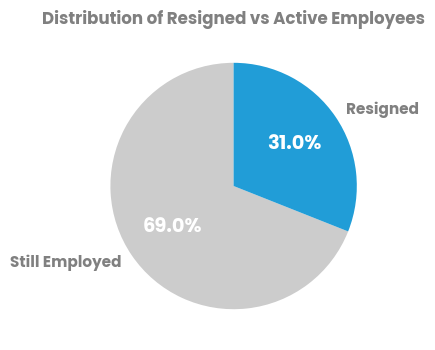

In [86]:
df_plot['AlasanResign'] = df_plot['AlasanResign'].replace('Product Design (UI & UX)', 'Others')
df_plot["Resign_label"] = df_plot["Resign"].map({1: "Resigned", 0: "Still Employed"})
resign_counts = df_plot['Resign_label'].value_counts()

fig, ax = plt.subplots(figsize=(4,4))
wedges, texts, autotexts = ax.pie(
    resign_counts,
    labels=resign_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#CCCCCC', '#219dd7'],
    textprops={'color':'white', 'weight':'bold', 'fontsize':14}
)
for text in texts:
    text.set_color('#808080')
    text.set_fontsize(11)

plt.title('Distribution of Resigned vs Active Employees')
plt.show()

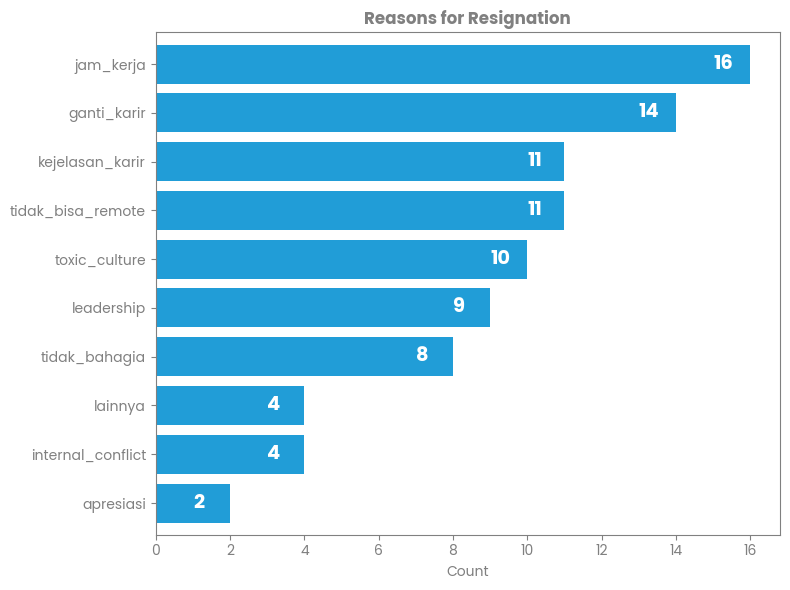

In [87]:
df_filtered = df_plot[df_plot['AlasanResign'] != 'masih_bekerja']
resign_counts = df_filtered['AlasanResign'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(8, 6))
resign_counts.plot(kind='barh', width=0.8, color='#219dd7')

plt.title('Reasons for Resignation')
plt.xlabel('Count')
plt.ylabel('')

for i, v in enumerate(resign_counts):
    plt.text(v - 1, i, str(v), va='center', ha='left', color='white', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## **2.2. Customer Demographics Analysis**


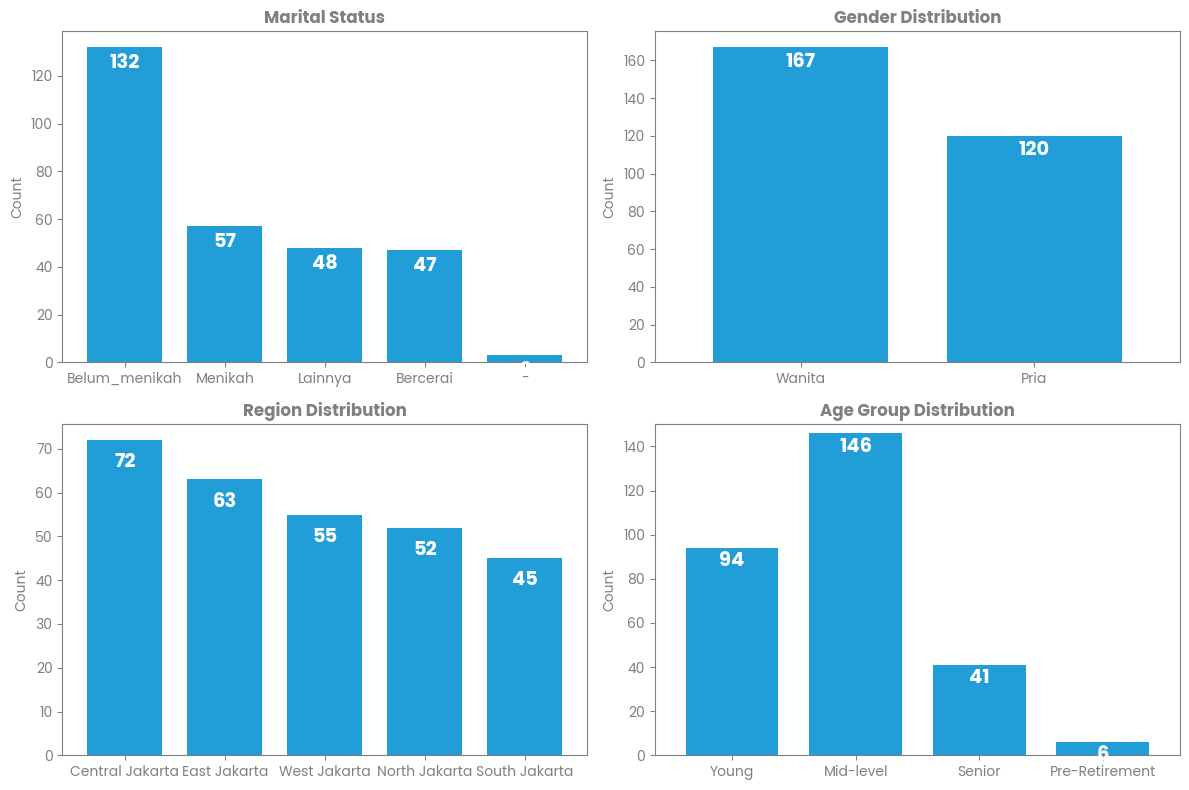

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Marital Status
status_counts = df_plot['StatusPernikahan'].value_counts().sort_values(ascending=False)
status_counts.plot(kind='bar', ax=axes[0], width=0.75)
axes[0].set_title('Marital Status')
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

for i, v in enumerate(status_counts):
    axes[0].text(i, v - 3, str(v), ha='center', va='top', color='white', fontsize=14, fontweight='bold')

# Gender
gender_counts = df_plot['JenisKelamin'].value_counts()
gender_counts.plot(kind='bar', ax=axes[1], width=0.75)
axes[1].set_title('Gender Distribution')
axes[1].set_xlabel('')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

for i, v in enumerate(gender_counts):
    axes[1].text(i, v - 3, str(v), ha='center', va='top', color='white', fontsize=14, fontweight='bold')

# Region of Origin
region_counts = df_plot['AsalDaerah'].value_counts()
mapping = {
    "Jakarta Utara": "North Jakarta",
    "Jakarta Selatan": "South Jakarta",
    "Jakarta Barat": "West Jakarta",
    "Jakarta Timur": "East Jakarta",
    "Jakarta Pusat": "Central Jakarta"
}
region_counts.index = region_counts.index.map(lambda x: mapping.get(x, x))
region_counts.plot(kind='bar', ax=axes[2], width=0.75)
axes[2].set_title('Region Distribution')
axes[2].set_xlabel('')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=0)

for i, v in enumerate(region_counts):
    axes[2].text(i, v - 3, str(v), ha='center', va='top', color='white', fontsize=14, fontweight='bold')

# Age Group
labels = ["Young", "Mid-level", "Senior", "Pre-Retirement"]
age_counts = df_plot['UsiaGroup'].value_counts().reindex(labels)
age_counts.plot(kind='bar', ax=axes[3], width=0.75)
axes[3].set_title('Age Group Distribution')
axes[3].set_xlabel('')
axes[3].set_ylabel('Count')
axes[3].set_ylim(0, 150)
axes[3].tick_params(axis='x', rotation=0)

for i, v in enumerate(age_counts):
    axes[3].text(i, v - 2, str(v), ha='center', va='top', color='white', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

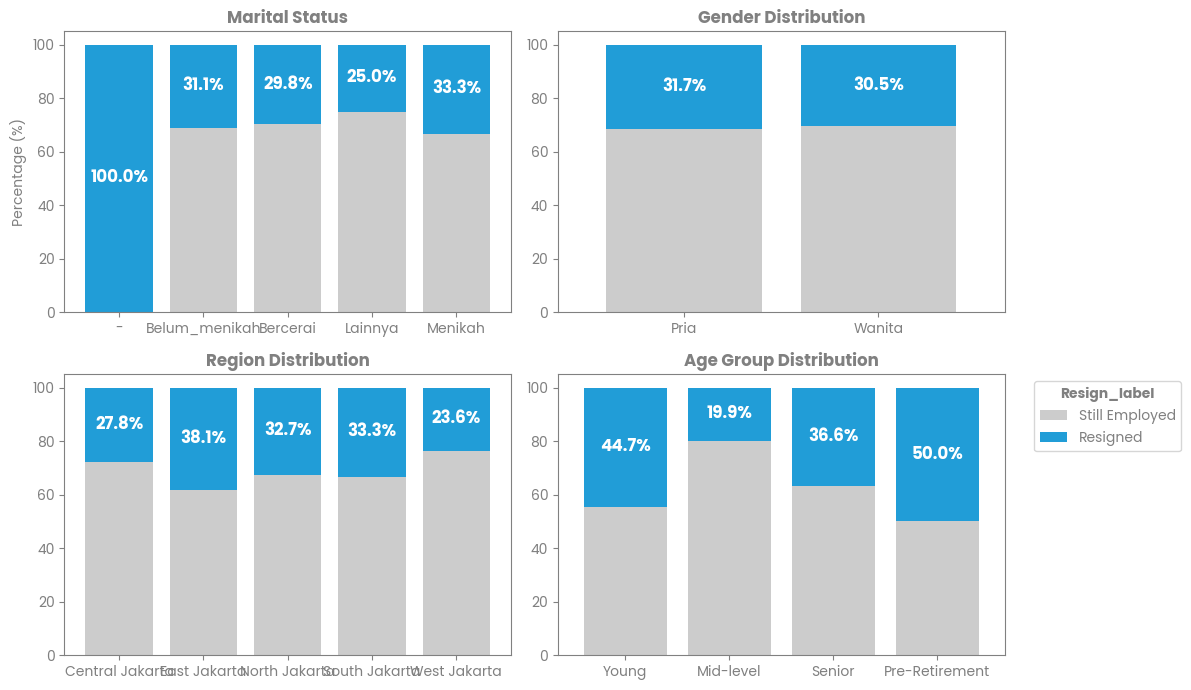

In [92]:
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Marital Status vs Resign
ctab_status = pd.crosstab(df_plot['StatusPernikahan'], df_plot['Resign_label'])
ctab_status = ctab_status[['Still Employed', 'Resigned']]
ctab_status_perc = ctab_status.div(ctab_status.sum(axis=1), axis=0) * 100

ctab_status_perc.plot(kind='bar', stacked=True, ax=ax0, width=0.8, legend=False, color=['#CCCCCC', '#219dd7'])
ax0.set_title('Marital Status')
ax0.set_xlabel('')
ax0.set_ylabel('Percentage (%)')
ax0.tick_params(axis='x', rotation=0)

for i, idx in enumerate(ctab_status_perc.index):
    yes_value = ctab_status_perc.loc[idx, 'Resigned']
    if yes_value > 0:
        ax0.text(i, 100 - yes_value/2, f'{yes_value:.1f}%', ha='center', va='center', color='white', fontweight='bold', fontsize=12)

# Gender vs Resign
ctab_gender = pd.crosstab(df_plot['JenisKelamin'], df_plot['Resign_label'])
ctab_gender = ctab_gender[['Still Employed', 'Resigned']]
ctab_gender_perc = ctab_gender.div(ctab_gender.sum(axis=1), axis=0) * 100

ctab_gender_perc.plot(kind='bar', stacked=True, ax=ax1, width=0.8, legend=False, color=['#CCCCCC', '#219dd7'])
ax1.set_title('Gender Distribution')
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=0)

for i, idx in enumerate(ctab_gender_perc.index):
    yes_value = ctab_gender_perc.loc[idx, 'Resigned']
    if yes_value > 0:
        ax1.text(i, 100 - yes_value/2, f'{yes_value:.1f}%', ha='center', va='center', color='white', fontweight='bold', fontsize=12)

# Region of Origin vs Resign
mapping = {
    "Jakarta Utara": "North Jakarta",
    "Jakarta Selatan": "South Jakarta",
    "Jakarta Barat": "West Jakarta",
    "Jakarta Timur": "East Jakarta",
    "Jakarta Pusat": "Central Jakarta"
}
df_plot['AsalDaerahMapped'] = df_plot['AsalDaerah'].map(lambda x: mapping.get(x, x))

ctab_region = pd.crosstab(df_plot['AsalDaerahMapped'], df_plot['Resign_label'])
ctab_region = ctab_region[['Still Employed', 'Resigned']]
ctab_region_perc = ctab_region.div(ctab_region.sum(axis=1), axis=0) * 100

ctab_region_perc.plot(kind='bar', stacked=True, ax=ax2, width=0.8, legend=False, color=['#CCCCCC', '#219dd7'])
ax2.set_title('Region Distribution')
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=0)

for i, idx in enumerate(ctab_region_perc.index):
    yes_value = ctab_region_perc.loc[idx, 'Resigned']
    if yes_value > 0:
        ax2.text(i, 100 - yes_value/2, f'{yes_value:.1f}%', ha='center', va='center', color='white', fontweight='bold', fontsize=12)

# Age Group vs Resign
ctab_age = pd.crosstab(df_plot['UsiaGroup'], df_plot['Resign_label'])
ctab_age = ctab_age[['Still Employed', 'Resigned']]
ctab_age_perc = ctab_age.div(ctab_age.sum(axis=1), axis=0) * 100

ctab_age_perc.plot(kind='bar', stacked=True, ax=ax3, width=0.8, legend=False, color=['#CCCCCC', '#219dd7'])
ax3.set_title('Age Group Distribution')
ax3.set_xlabel('')
ax3.tick_params(axis='x', rotation=0)

for i, idx in enumerate(ctab_age_perc.index):
    yes_value = ctab_age_perc.loc[idx, 'Resigned']
    if yes_value > 0:
        ax3.text(i, 100 - yes_value/2, f'{yes_value:.1f}%', ha='center', va='center', color='white', fontweight='bold', fontsize=12)

# Legend
legend = ax3.legend(title='Resign_label', bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_title().set_color('#808080')
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()

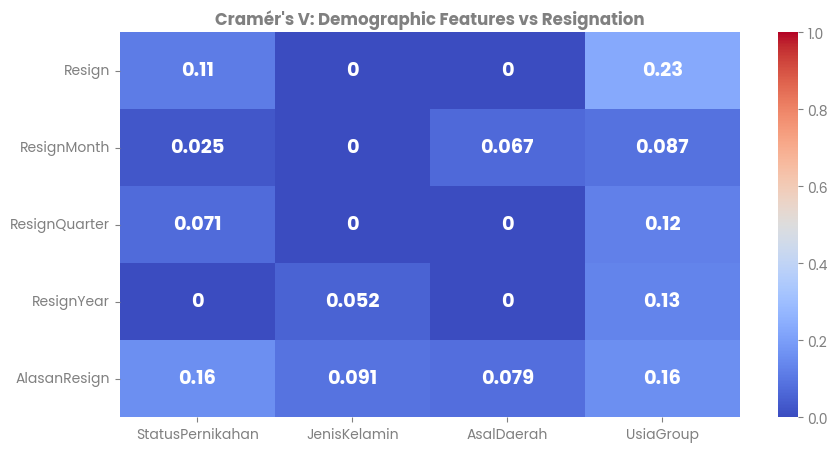

In [93]:
# Cramér's V function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

df_plot['ResignMonth'] = df_plot['TanggalResign'].dt.month.astype(str)
df_plot['ResignQuarter'] = 'Q' + df_plot['TanggalResign'].dt.quarter.astype(str)
df_plot['ResignYear'] = df_plot['TanggalResign'].dt.year.astype(str)

features = ['StatusPernikahan', 'JenisKelamin', 'AsalDaerah', 'UsiaGroup']
targets = ['Resign', 'ResignMonth', 'ResignQuarter', 'ResignYear', 'AlasanResign']
cramers_matrix = pd.DataFrame(index=targets, columns=features, dtype=float)

for target in targets:
    for feature in features:
        cramers_matrix.loc[target, feature] = cramers_v(df_plot[feature], df_plot[target])

plt.figure(figsize=(10,5))
sns.heatmap(
    cramers_matrix.astype(float),
    annot=True,
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    annot_kws={"size": 14, "weight": "bold"},
    yticklabels=True,
    xticklabels=True
)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title("Cramér's V: Demographic Features vs Resignation")
plt.xlabel("")
plt.ylabel("")
plt.show()

## **2.3. Employee Performance Analysis**

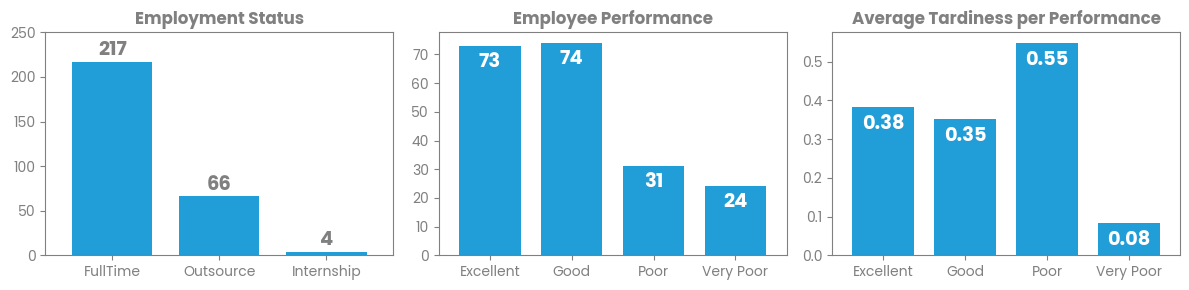

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Employment Status
status_counts = df_plot['StatusKepegawaian'].value_counts()
status_counts.plot(kind='bar', ax=axes[0], width=0.75)
axes[0].set_title('Employment Status')
axes[0].set_xlabel('')
axes[0].set_ylim(0, 250)
axes[0].tick_params(axis='x', rotation=0)
for i, v in enumerate(status_counts):
    axes[0].text(i, v + 2, str(v), ha='center', va='bottom', fontsize=14, fontweight='bold', color='#808080')

# Employee Performance
performance_order = ['Sangat_bagus', 'Bagus', 'Cukup', 'Kurang', 'Sangat_kurang']
performance_labels = {
    'Sangat_bagus': 'Excellent',
    'Bagus': 'Good',
    'Cukup': 'Fair',
    'Kurang': 'Poor',
    'Sangat_kurang': 'Very Poor'
}
perf_counts = df_plot['PerformancePegawai'].value_counts().reindex([p for p in performance_order if p in df_plot['PerformancePegawai'].unique()])
perf_counts.plot(kind='bar', ax=axes[1], width=0.75)

axes[1].set_title('Employee Performance')
axes[1].set_xlabel('')
axes[1].set_xticklabels([performance_labels.get(p, p) for p in perf_counts.index], rotation=0)

for i, v in enumerate(perf_counts):
    axes[1].text(i, v - 9, str(v), ha='center', va='bottom', fontsize=14, fontweight='bold', color='white')

# Average Tardiness per Performance
delay_means = df_plot.groupby('PerformancePegawai')['JumlahKeterlambatanSebulanTerakhir'].mean().reindex([p for p in performance_order if p in df_plot['PerformancePegawai'].unique()])
delay_means.plot(kind='bar', ax=axes[2], width=0.75)
axes[2].set_title('Average Tardiness per Performance')
axes[2].set_xlabel('')
axes[2].tick_params(axis='x', rotation=0)
axes[2].set_xticklabels([performance_labels.get(p, p) for p in delay_means.index], rotation=0)

for i, v in enumerate(delay_means):
    axes[2].text(i, v - 0.07, f'{v:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

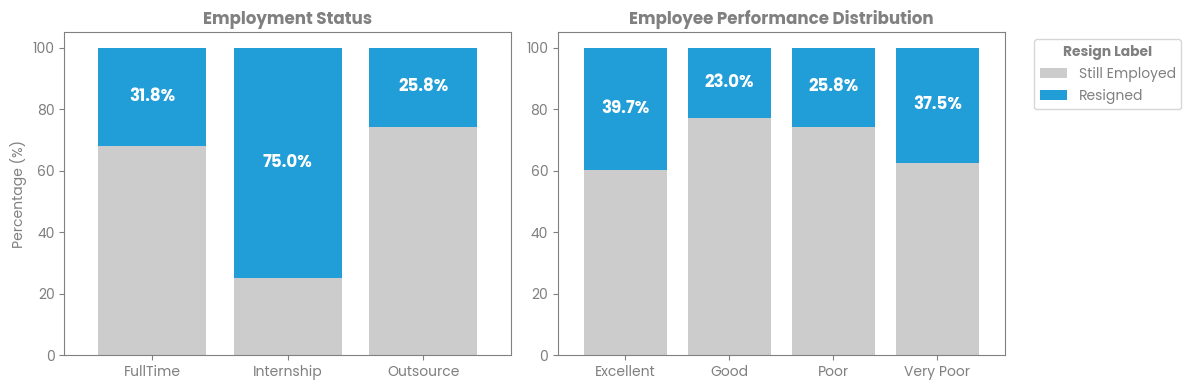

In [111]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

# Employment Status
ctab_status = pd.crosstab(df_plot['StatusKepegawaian'], df_plot['Resign_label'])
ctab_status = ctab_status[['Still Employed', 'Resigned']]
ctab_status_perc = ctab_status.div(ctab_status.sum(axis=1), axis=0) * 100

ctab_status_perc.plot(kind='bar', stacked=True, ax=ax0, width=0.8, legend=False, color=['#CCCCCC', '#219dd7'])
ax0.set_title('Employment Status')
ax0.set_xlabel('')
ax0.set_ylabel('Percentage (%)')
ax0.tick_params(axis='x', rotation=0)

for i, idx in enumerate(ctab_status_perc.index):
    yes_value = ctab_status_perc.loc[idx, 'Resigned']
    if yes_value > 0:
        ax0.text(i, 100 - yes_value/2, f'{yes_value:.1f}%', ha='center', va='center', color='white', fontweight='bold', fontsize=12)

# Employee Performance
# Define order and mapping
performance_order = ['Sangat_bagus', 'Bagus', 'Cukup', 'Kurang', 'Sangat_kurang']
performance_labels = {
    'Sangat_bagus': 'Excellent',
    'Bagus': 'Good',
    'Cukup': 'Fair',
    'Kurang': 'Poor',
    'Sangat_kurang': 'Very Poor'
}

# Crosstab
ctab_perf = pd.crosstab(df_plot['PerformancePegawai'], df_plot['Resign_label'])
ctab_perf = ctab_perf[['Still Employed', 'Resigned']]  # pastikan urutannya benar
ctab_perf = ctab_perf.reindex([p for p in performance_order if p in ctab_perf.index])
ctab_perf_perc = ctab_perf.div(ctab_perf.sum(axis=1), axis=0) * 100
ctab_perf_perc.plot(kind='bar', stacked=True, ax=ax1, width=0.8, legend=False, color=['#CCCCCC', '#219dd7'])

ax1.set_title('Employee Performance Distribution')
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=0)
ax1.set_xticklabels([performance_labels.get(idx, idx) for idx in ctab_perf_perc.index])

for i, idx in enumerate(ctab_perf_perc.index):
    yes_value = ctab_perf_perc.loc[idx, 'Resigned']
    if yes_value > 0:
        ax1.text(i, 100 - yes_value/2, f'{yes_value:.1f}%', ha='center', va='center', color='white', fontweight='bold', fontsize=12)

legend = ax1.legend(title='Resign Label', bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_title().set_color('#808080')
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()

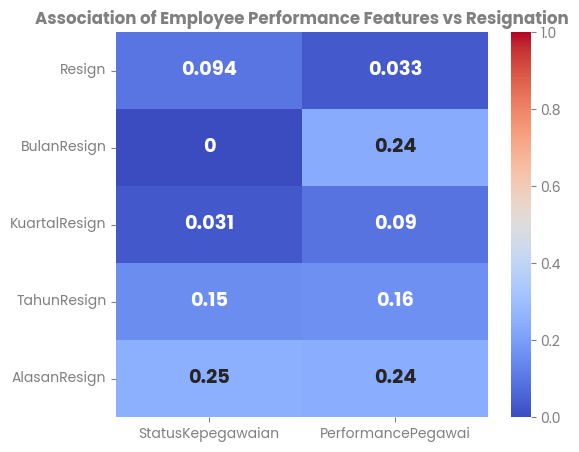

In [112]:
ordinal_mapping = {
    'Sangat_kurang': 1,
    'Kurang': 2,
    'Biasa': 3,
    'Bagus': 4,
    'Sangat_bagus': 5
}

df_plot['PerformancePegawai'] = df_plot['PerformancePegawai'].map(ordinal_mapping)

# Cramér's V function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Correlation ratio function
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(cat_num):
        cat_measures = measurements[fcat==i]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.mean(cat_measures) if len(cat_measures) > 0 else 0
    y_total_avg = np.sum(y_avg_array * n_array) / np.sum(n_array)
    numerator = np.sum(n_array * (y_avg_array - y_total_avg)**2)
    denominator = np.sum((measurements - y_total_avg)**2)
    return np.sqrt(numerator/denominator) if denominator != 0 else 0

features = ['StatusKepegawaian', 'PerformancePegawai']
targets = ['Resign', 'BulanResign', 'KuartalResign', 'TahunResign', 'AlasanResign']
assoc_matrix = pd.DataFrame(index=targets, columns=features, dtype=float)

for target in targets:
    for feature in features:
        if feature == 'PerformancePegawai':
            assoc_matrix.loc[target, feature] = correlation_ratio(df_plot[target], df_plot[feature])
        else:
            assoc_matrix.loc[target, feature] = cramers_v(df_plot[feature], df_plot[target])

plt.figure(figsize=(6,5))
sns.heatmap(assoc_matrix.astype(float), annot=True, cmap="coolwarm", vmin=0, vmax=1,
            annot_kws={"size": 14, "weight": "bold"}, yticklabels=True, xticklabels=True)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title("Association of Employee Performance Features vs Resignation")
plt.show()

## **2.4. Engagement & Satisfaction Analysis**

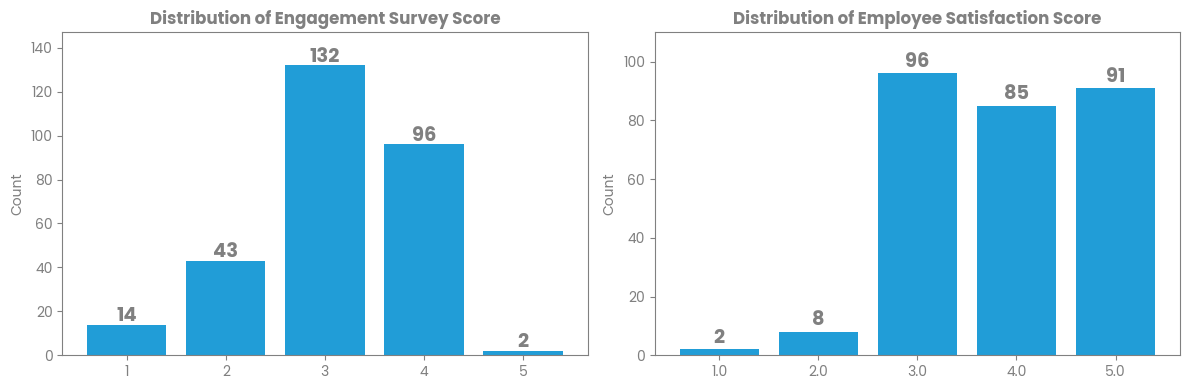

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Engagement Survey Score
status_counts = df_plot['SkorSurveyEngagement'].value_counts().sort_index()
status_counts.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Distribution of Engagement Survey Score')
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, 147)
axes[0].tick_params(axis='x', rotation=0)

for i, v in enumerate(status_counts):
    axes[0].text(i, v + 8, str(v), ha='center', va='top', color='#808080', fontsize=14, fontweight='bold')

# Employee Satisfaction Score
jenis_counts = df_plot['SkorKepuasanPegawai'].value_counts().sort_index()
jenis_counts.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Distribution of Employee Satisfaction Score')
axes[1].set_xlabel('')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, 110)
axes[1].tick_params(axis='x', rotation=0)

for i, v in enumerate(jenis_counts):
    axes[1].text(i, v + 7, str(v), ha='center', va='top', color='#808080', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

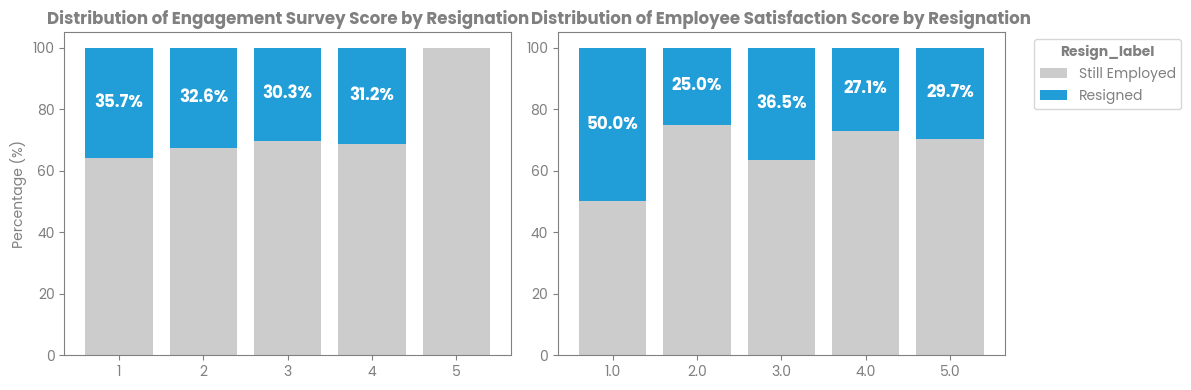

In [117]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

# Engagement Survey Score
ctab_engagement = pd.crosstab(df_plot['SkorSurveyEngagement'], df_plot['Resign_label'])
ctab_engagement = ctab_engagement[['Still Employed', 'Resigned']]
ctab_engagement_perc = ctab_engagement.div(ctab_engagement.sum(axis=1), axis=0) * 100

ctab_engagement_perc.plot(kind='bar', stacked=True, ax=ax0, width=0.8, legend=False, color=['#CCCCCC', '#219dd7'])
ax0.set_title('Distribution of Engagement Survey Score by Resignation')
ax0.set_xlabel('')
ax0.set_ylabel('Percentage (%)')
ax0.tick_params(axis='x', rotation=0)

for i, idx in enumerate(ctab_engagement_perc.index):
    yes_value = ctab_engagement_perc.loc[idx, 'Resigned']
    if yes_value > 0:
        ax0.text(i, 100 - yes_value/2, f'{yes_value:.1f}%', ha='center', va='center', color='white', fontweight='bold', fontsize=12)

# Employee Satisfaction Score
ctab_kepuasan = pd.crosstab(df_plot['SkorKepuasanPegawai'], df_plot['Resign_label'])
ctab_kepuasan = ctab_kepuasan[['Still Employed', 'Resigned']]
ctab_kepuasan_perc = ctab_kepuasan.div(ctab_kepuasan.sum(axis=1), axis=0) * 100

ctab_kepuasan_perc.plot(kind='bar', stacked=True, ax=ax1, width=0.8, legend=False, color=['#CCCCCC', '#219dd7'])
ax1.set_title('Distribution of Employee Satisfaction Score by Resignation')
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=0)

for i, idx in enumerate(ctab_kepuasan_perc.index):
    yes_value = ctab_kepuasan_perc.loc[idx, 'Resigned']
    if yes_value > 0:
        ax1.text(i, 100 - yes_value/2, f'{yes_value:.1f}%', ha='center', va='center', color='white', fontweight='bold', fontsize=12)

# Legend
legend = ax1.legend(title='Resign_label', bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_title().set_color('#808080')
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()

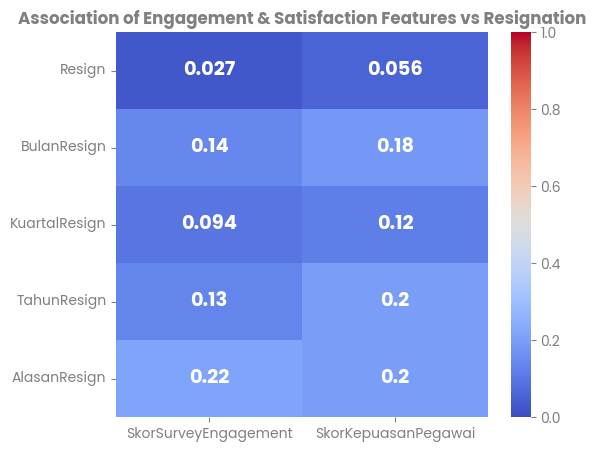

In [115]:
# Cramér's V function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Correlation ratio function
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(cat_num):
        cat_measures = measurements[fcat==i]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.mean(cat_measures) if len(cat_measures) > 0 else 0
    y_total_avg = np.sum(y_avg_array * n_array) / np.sum(n_array)
    numerator = np.sum(n_array * (y_avg_array - y_total_avg)**2)
    denominator = np.sum((measurements - y_total_avg)**2)
    return np.sqrt(numerator/denominator) if denominator != 0 else 0

features = ['SkorSurveyEngagement', 'SkorKepuasanPegawai']
targets = ['Resign', 'BulanResign', 'KuartalResign', 'TahunResign', 'AlasanResign']
assoc_matrix = pd.DataFrame(index=targets, columns=features, dtype=float)

for target in targets:
    for feature in features:
        assoc_matrix.loc[target, feature] = correlation_ratio(df_plot[target], df_plot[feature])

plt.figure(figsize=(6,5))
sns.heatmap(assoc_matrix.astype(float), annot=True, cmap="coolwarm", vmin=0, vmax=1,
            annot_kws={"size": 14, "weight": "bold"}, yticklabels=True, xticklabels=True)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title("Association of Engagement & Satisfaction Features vs Resignation")
plt.show()

## **2.5. Hiring & Process Analysis**

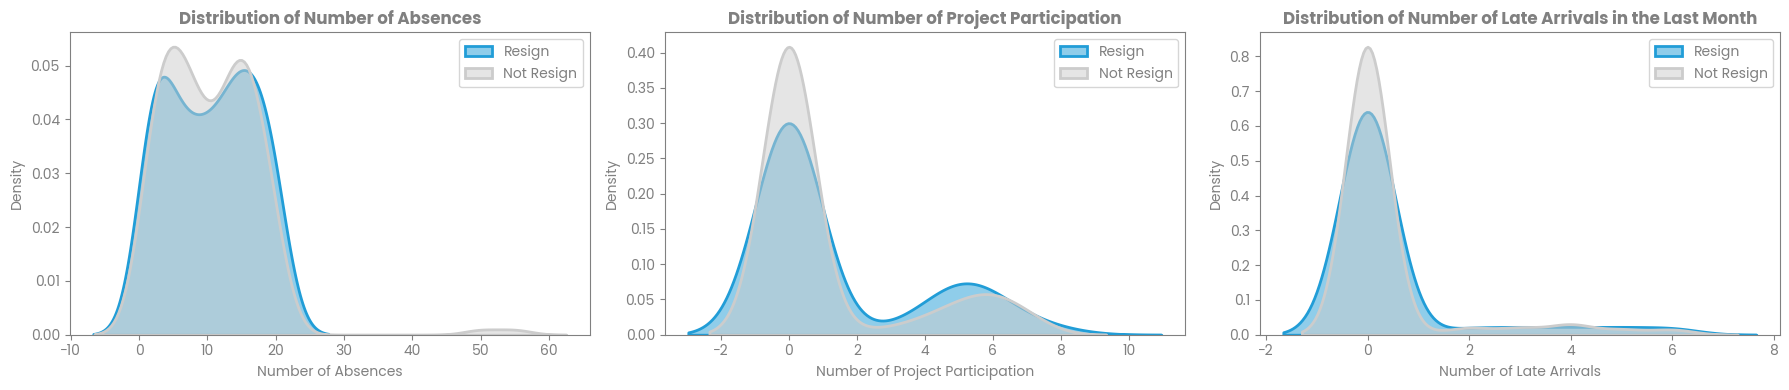

In [120]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Number of Absences
sns.kdeplot(
    data=df_plot[df_plot['Resign_label']=='Resigned'],
    x='JumlahKetidakhadiran',
    fill=True, alpha=0.5, linewidth=2, color='#219dd7', label='Resign', ax=axes[0]
)
sns.kdeplot(
    data=df_plot[df_plot['Resign_label']=='Still Employed'],
    x='JumlahKetidakhadiran',
    fill=True, alpha=0.5, linewidth=2, color='#cccccc', label='Not Resign', ax=axes[0]
)
axes[0].set_title('Distribution of Number of Absences')
axes[0].set_xlabel('Number of Absences')
axes[0].set_ylabel('Density')
axes[0].legend()

# Number of Project Participation
sns.kdeplot(
    data=df_plot[df_plot['Resign_label']=='Resigned'],
    x='JumlahKeikutsertaanProjek',
    fill=True, alpha=0.5, linewidth=2, color='#219dd7', label='Resign', ax=axes[1]
)
sns.kdeplot(
    data=df_plot[df_plot['Resign_label']=='Still Employed'],
    x='JumlahKeikutsertaanProjek',
    fill=True, alpha=0.5, linewidth=2, color='#cccccc', label='Not Resign', ax=axes[1]
)
axes[1].set_title('Distribution of Number of Project Participation')
axes[1].set_xlabel('Number of Project Participation')
axes[1].set_ylabel('Density')
axes[1].legend()

# Number of Late Arrivals in the Last Month
sns.kdeplot(
    data=df_plot[df_plot['Resign_label']=='Resigned'],
    x='JumlahKeterlambatanSebulanTerakhir',
    fill=True, alpha=0.5, linewidth=2, color='#219dd7', label='Resign', ax=axes[2]
)
sns.kdeplot(
    data=df_plot[df_plot['Resign_label']=='Still Employed'],
    x='JumlahKeterlambatanSebulanTerakhir',
    fill=True, alpha=0.5, linewidth=2, color='#cccccc', label='Not Resign', ax=axes[2]
)
axes[2].set_title('Distribution of Number of Late Arrivals in the Last Month')
axes[2].set_xlabel('Number of Late Arrivals')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout()
plt.show()

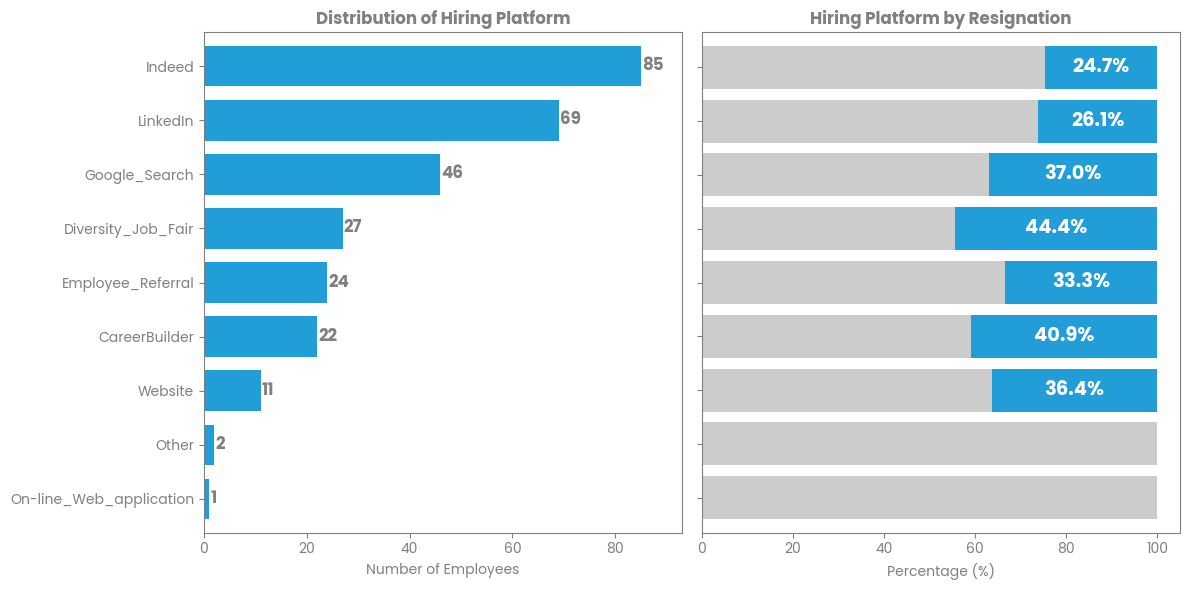

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar Chart
status_counts = df_plot['HiringPlatform'].value_counts().sort_values(ascending=True)
status_counts.plot(kind='barh', ax=axes[0], width=0.75)
axes[0].set_title('Distribution of Hiring Platform')
axes[0].set_xlim(0, 93)
axes[0].set_xlabel('Number of Employees')
axes[0].set_ylabel('')

for i, v in enumerate(status_counts):
    axes[0].text(v + 0.2, i, str(v), ha='left', va='center', fontsize=12, fontweight='bold', color='#808080')

# Hiring vs Resignation
ctab_hiring = pd.crosstab(df_plot['HiringPlatform'], df_plot['Resign_label'])
ctab_hiring = ctab_hiring[['Still Employed', 'Resigned']]
ctab_hiring_perc = ctab_hiring.div(ctab_hiring.sum(axis=1), axis=0) * 100

ctab_hiring_perc.loc[status_counts.index].plot(kind='barh', stacked=True, ax=axes[1], width=0.8, legend=False, color=['#CCCCCC', '#219dd7'])
axes[1].set_title('Hiring Platform by Resignation')
axes[1].set_xlabel('Percentage (%)')
axes[1].set_ylabel('')
axes[1].tick_params(axis='y', rotation=0)
axes[1].set_yticklabels([])

for i, idx in enumerate(status_counts.index):
    yes_value = ctab_hiring_perc.loc[idx, 'Resigned']
    if yes_value > 0:
        axes[1].text(100 - yes_value/2, i, f'{yes_value:.1f}%', va='center', ha='center', color='white', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

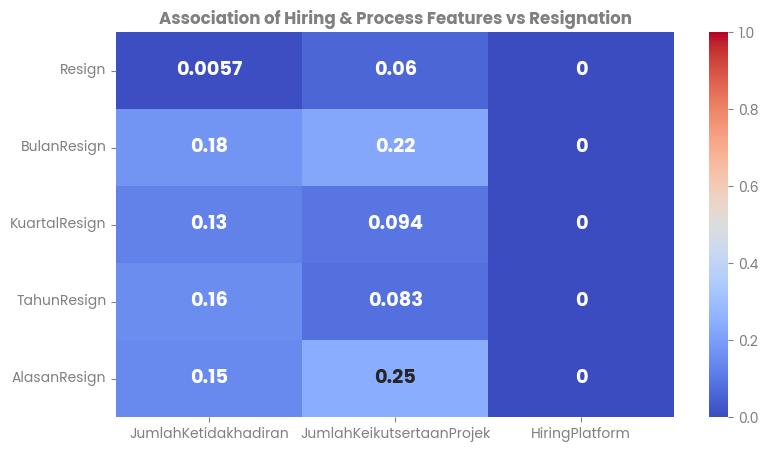

In [122]:
# Cramér's V function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Correlation ratio function
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(cat_num):
        cat_measures = measurements[fcat==i]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.mean(cat_measures) if len(cat_measures) > 0 else 0
    y_total_avg = np.sum(y_avg_array * n_array) / np.sum(n_array)
    numerator = np.sum(n_array * (y_avg_array - y_total_avg)**2)
    denominator = np.sum((measurements - y_total_avg)**2)
    return np.sqrt(numerator/denominator) if denominator != 0 else 0

features = ['JumlahKetidakhadiran', 'JumlahKeikutsertaanProjek', 'HiringPlatform']
targets = ['Resign', 'BulanResign', 'KuartalResign', 'TahunResign', 'AlasanResign']
assoc_matrix = pd.DataFrame(index=targets, columns=features, dtype=float)

for target in targets:
    for feature in features:
        if feature == 'HiringPlatform':
            assoc_matrix.loc[target, feature] = cramers_v(df_plot[feature], df_plot[target])
        else:
            assoc_matrix.loc[target, feature] = correlation_ratio(df_plot[target], df_plot[feature])

plt.figure(figsize=(9,5))
sns.heatmap(assoc_matrix.astype(float), annot=True, cmap="coolwarm", vmin=0, vmax=1,
            annot_kws={"size": 14, "weight": "bold"}, yticklabels=True, xticklabels=True)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title("Association of Hiring & Process Features vs Resignation")
plt.show()

## **2.6. Temporal Analysis**


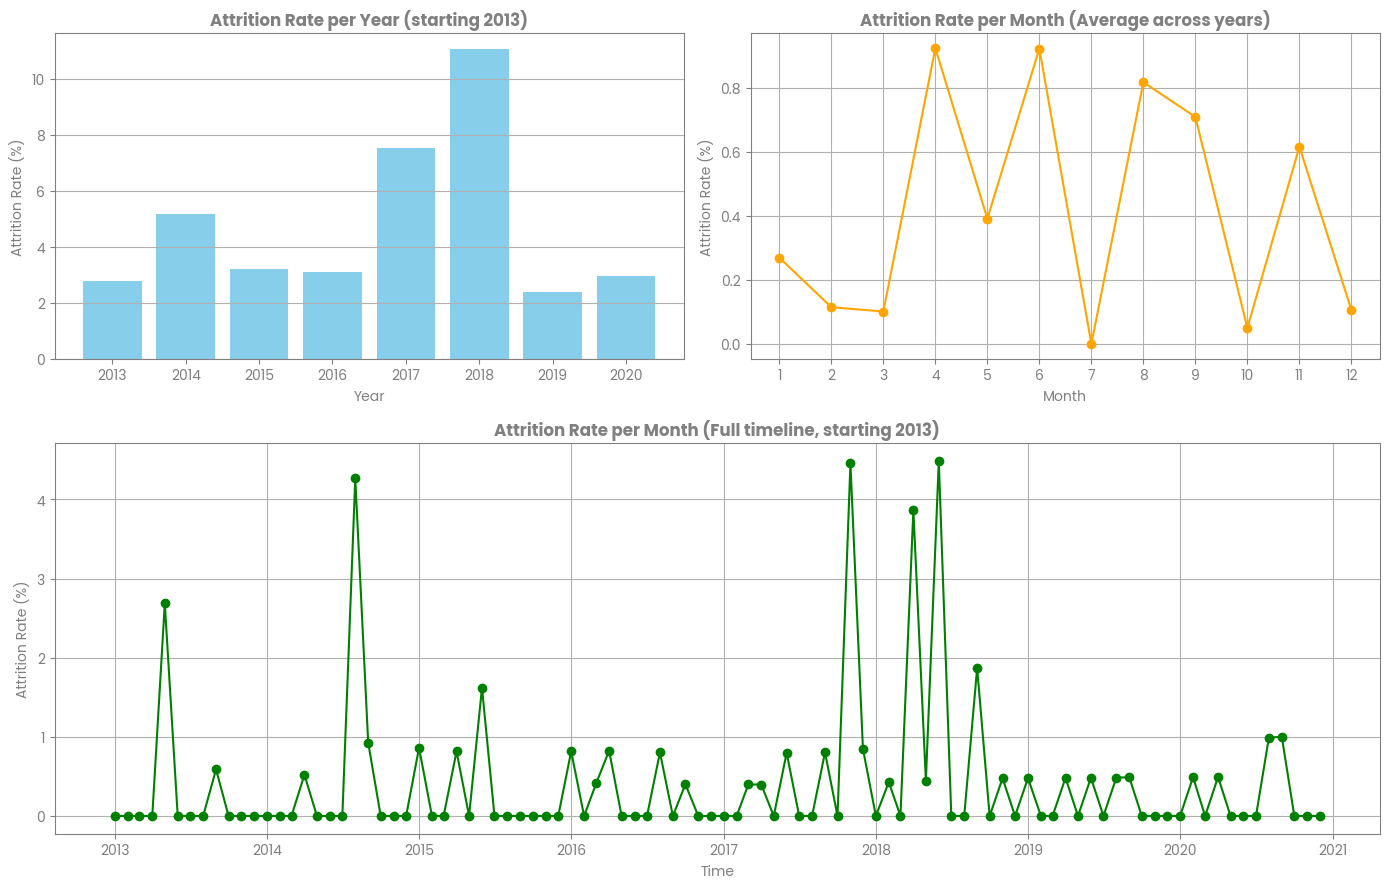

In [127]:
df_plot["TahunHiring"] = df_plot["TanggalHiring"].dt.year
df_plot["BulanHiring"] = df_plot["TanggalHiring"].dt.month
df_plot["TahunResign"] = df_plot["TanggalResign"].dt.year
df_plot["BulanResign"] = df_plot["TanggalResign"].dt.month

last_year = max(df_plot["TahunHiring"].max(), df_plot["TahunResign"].dropna().max())

df_plot["TahunHiring"] = df_plot["TahunHiring"].astype(int)
df_plot["TahunResign"] = df_plot["TahunResign"].fillna(last_year).astype(int)
df_plot["BulanResign"] = df_plot["BulanResign"].fillna(12).astype(int)

years = range(2013, df_plot["TahunResign"].max() + 1)

attrition_rate_year = {}
for year in years:
    resigned = len(df_plot[(df_plot["TahunResign"] == year) & (df_plot["Resign"] == 1)])
    active = df_plot[(df_plot["TahunHiring"] <= year) & (df_plot["TahunResign"] >= year)]
    total = len(active)
    attrition_rate_year[year] = (resigned / total * 100) if total > 0 else 0

df_plot["PeriodeResign"] = pd.to_datetime(
    df_plot["TahunResign"].astype(str) + "-" + df_plot["BulanResign"].astype(str) + "-01",
    errors="coerce"
)

monthly_resign = df_plot[df_plot["Resign"] == 1].groupby("PeriodeResign").size()

all_months = pd.date_range(
    start="2013-01",
    end=f"{df_plot['TahunResign'].max()}-12",
    freq="MS"
)

monthly_total = []
for month in all_months:
    active = df_plot[
        (pd.to_datetime(df_plot["TahunHiring"].astype(str) + "-" +
                        df_plot["BulanHiring"].astype(str) + "-01") <= month) &
        (df_plot["PeriodeResign"] >= month)
    ]
    monthly_total.append(len(active))

monthly_total = pd.Series(monthly_total, index=all_months)
attrition_rate_month = (monthly_resign / monthly_total * 100).reindex(all_months).fillna(0)
attrition_by_month = attrition_rate_month.groupby(attrition_rate_month.index.month).mean()

fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

# Yearly graph
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(list(attrition_rate_year.keys()), list(attrition_rate_year.values()), color="skyblue")
ax1.set_title("Attrition Rate per Year (starting 2013)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Attrition Rate (%)")
ax1.grid(True, axis="y")

# Monthly pattern across years
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(range(1, 13), attrition_by_month.values, marker="o", color="orange")
ax2.set_title("Attrition Rate per Month (Average across years)")
ax2.set_xlabel("Month")
ax2.set_ylabel("Attrition Rate (%)")
ax2.set_xticks(range(1, 13))
ax2.grid(True)

# Full monthly timeline
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(attrition_rate_month.index, attrition_rate_month.values, marker="o", color="green")
ax3.set_title("Attrition Rate per Month (Full timeline, starting 2013)")
ax3.set_xlabel("Time")
ax3.set_ylabel("Attrition Rate (%)")
ax3.grid(True)

plt.tight_layout()
plt.show()

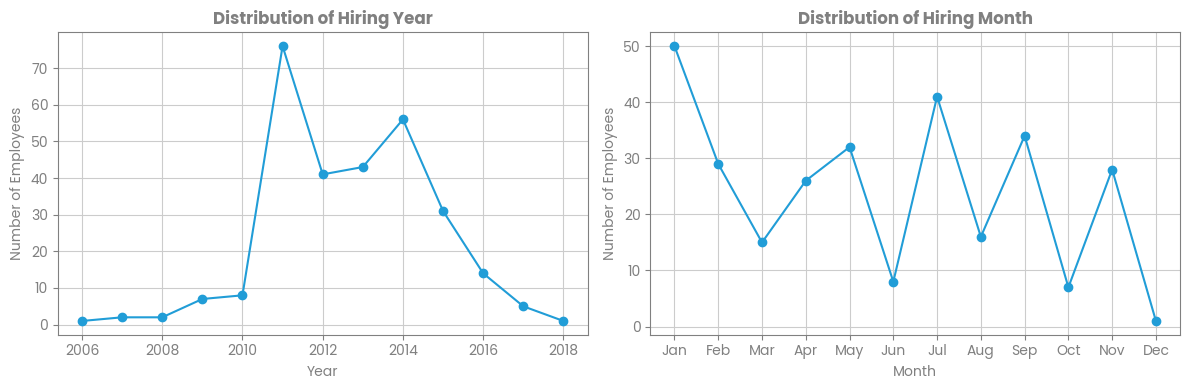

In [129]:
df_plot['TanggalHiring'] = pd.to_datetime(df_plot['TanggalHiring'])
df_plot['TahunHiring'] = df_plot['TanggalHiring'].dt.year
tahun_hiring_counts = df_plot['TahunHiring'].value_counts().sort_index()

df_plot['BulanHiring'] = df_plot['TanggalHiring'].dt.month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bulan_counts = df_plot['BulanHiring'].value_counts().sort_index()
bulan_counts.index = [month_names[i-1] for i in bulan_counts.index]

fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].plot(tahun_hiring_counts.index, tahun_hiring_counts.values, marker='o', linestyle='-')
axes[0].set_title('Distribution of Hiring Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Employees')
axes[0].grid(True, color='#CCCCCC')

axes[1].plot(bulan_counts.index, bulan_counts.values, marker='o', linestyle='-')
axes[1].set_title('Distribution of Hiring Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Employees')
axes[1].grid(True, color='#CCCCCC')

plt.tight_layout()
plt.show()

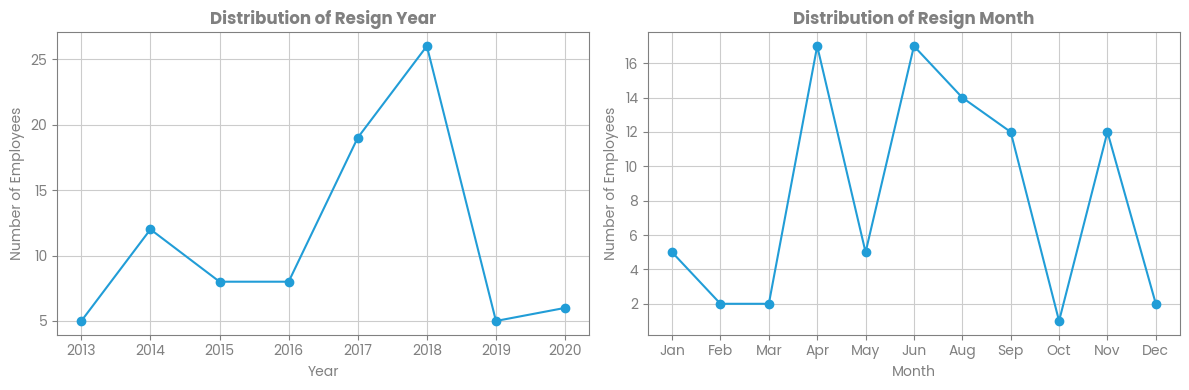

In [130]:
df_plot['TanggalResign'] = pd.to_datetime(df_plot['TanggalResign'], errors='coerce')
df_plot['TahunResign'] = df_plot['TanggalResign'].dt.year
tahun_resign_counts = df_plot['TahunResign'].dropna().astype(int).value_counts().sort_index()

df_plot['BulanResign'] = df_plot['TanggalResign'].dt.month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bulan_counts = df_plot['BulanResign'].dropna().astype(int).value_counts().sort_index()
bulan_counts.index = [month_names[i-1] for i in bulan_counts.index]

fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].plot(tahun_resign_counts.index, tahun_resign_counts.values, marker='o', linestyle='-')
axes[0].set_title('Distribution of Resign Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Employees')
axes[0].grid(True, color='#CCCCCC')

axes[1].plot(bulan_counts.index, bulan_counts.values, marker='o', linestyle='-')
axes[1].set_title('Distribution of Resign Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Employees')
axes[1].grid(True, color='#CCCCCC')

plt.tight_layout()
plt.show()

# **3. Attrition Prediction**

## **Baseline**

In [8]:
categorical_features = ['performance_numeric','education_rank','engagement_tier','satisfaction_tier','tenure_tier','age_tier','StatusPernikahan_encoded','JenisKelamin_encoded','StatusKepegawaian_encoded','JenjangKarir_encoded','PerformancePegawai_encoded','TingkatPendidikan_encoded','age_category_encoded','Pekerjaan_encoded','AsalDaerah_encoded','HiringPlatform_encoded','behavioral_cluster_3','behavioral_cluster_5','behavioral_cluster_7','professional_cluster','bulan_hiring','quarter_hiring','day_of_week_hiring','is_weekend_hiring','is_q1_hiring','is_q4_hiring','high_perf_high_eng','high_perf_low_eng','low_perf_high_eng','low_perf_low_eng','satisfaction_below_engagement','misaligned_perf_satisfaction','has_attendance_issues','chronic_lateness','chronic_absence','overqualified','underqualified','senior_low_performer','junior_high_performer','freshgrad_too_long','no_projects','low_project_participation','young_unmarried','young_married','mid_age_unmarried','female_senior','male_junior','is_outsource','is_permanent','insecure_employment','secure_employment','Pekerjaan_is_rare','Pekerjaan_is_common','AsalDaerah_is_rare','AsalDaerah_is_common','HiringPlatform_is_rare','HiringPlatform_is_common','early_career','mid_career','senior_career']
numeric_features = ['SkorSurveyEngagement','SkorKepuasanPegawai','JumlahKeikutsertaanProjek','JumlahKeterlambatanSebulanTerakhir','JumlahKetidakhadiran','masa_kerja_hingga_sekarang','umur_saat_hiring','umur_sekarang','hari_sejak_penilaian','bulan_sejak_penilaian','tahun_hiring','hiring_vintage','umur_saat_evaluasi','career_start_age','days_since_hiring','days_since_birth','engagement_satisfaction_gap','performance_satisfaction_alignment','total_attendance_issues','attendance_rate','reliability_weighted','engagement_squared','satisfaction_squared','tenure_squared','age_squared','eng_sat_tenure','perf_eng_age','attend_perf_tenure','projects_per_year','engagement_per_age','performance_per_tenure','Pekerjaan_frequency','AsalDaerah_frequency','HiringPlatform_frequency','flight_risk_score','performance_risk','career_stagnation_risk','ultimate_flight_risk','employee_value_score','pca_component_0','pca_component_1','pca_component_2','pca_component_3','pca_component_4']

X = df_processed.drop(['target'], axis=1)
y = df_processed['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
class OutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor  # Faktor IQR
        self.medians_ = {}

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=numeric_features)
        for col in X_df.columns:
            self.medians_[col] = X_df[col].median()
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=numeric_features)
        for col in X_df.columns:
            Q1 = X_df[col].quantile(0.25)
            Q3 = X_df[col].quantile(0.75)
            lower = Q1 - self.factor * (Q3 - Q1)
            upper = Q3 + self.factor * (Q3 - Q1)
            X_df[col] = X_df[col].mask((X_df[col] < lower) | (X_df[col] > upper), self.medians_[col])
        return X_df.values

class MixedImputer:
    def fit(self, X, y=None):
        if 'SkorKepuasanPegawai' in X.columns:
            self.mode_value = X['SkorKepuasanPegawai'].mode().iloc[0]
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        self.median_values = X[numeric_cols].median()
        return self

    def transform(self, X):
        X_copy = X.copy()
        if 'SkorKepuasanPegawai' in X_copy.columns and hasattr(self, 'mode_value'):
            X_copy['SkorKepuasanPegawai'] = X_copy['SkorKepuasanPegawai'].fillna(self.mode_value)
        if hasattr(self, 'median_values'):
            for col in self.median_values.index:
                if col in X_copy.columns:
                    X_copy[col] = X_copy[col].fillna(self.median_values[col])
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

cat_features_indices = [i for i, col in enumerate(X_train.columns) if col in categorical_features]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('outlier', OutlierImputer()),
            ('scaler', RobustScaler())
        ]), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ],
    remainder='passthrough'
)

def create_pipeline(model, apply_smote=False):
    if apply_smote:
        pipeline = ImbPipeline([
            ('imputer', MixedImputer()),
            ('preprocessor', preprocessor),
            ('smote', SMOTENC(categorical_features=cat_features_indices, random_state=42)),
            ('classifier', model)
        ])
    else:
        pipeline = Pipeline([
            ('imputer', MixedImputer()),
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
    return pipeline

In [10]:
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RidgeClassifier': RidgeClassifier(random_state=42),
    'SGDClassifier': SGDClassifier(random_state=42, max_iter=1000),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVC': SVC(probability=True, random_state=42),
    'LinearSVC': LinearSVC(random_state=42, max_iter=5000),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'Bagging': BaggingClassifier(random_state=42),
    'Stacking': StackingClassifier(
        estimators=[
            ('lr', LogisticRegression(random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
        ],
        final_estimator=GradientBoostingClassifier(n_estimators=100, random_state=42),
        cv=5
    ),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    'PassiveAggressive': PassiveAggressiveClassifier(random_state=42, max_iter=1000)
}

cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['f1', 'recall', 'precision', 'roc_auc']
results_list = []

for model_name, model in models.items():
    try:
        pipeline = create_pipeline(model, apply_smote=False)
        cv_scores = {}
        for metric in scoring_metrics:
            scores = cross_val_score(pipeline, X_train, y_train, cv=cv_folds,
                                     scoring=metric, n_jobs=-1)
            cv_scores[metric] = scores.mean()

        results_list.append({
            'Model': model_name,
            'F1': cv_scores['f1'],
            'Recall': cv_scores['recall'],
            'Precision': cv_scores['precision'],
            'ROC_AUC': cv_scores['roc_auc']
        })

    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")
        continue

results_df = pd.DataFrame(results_list).sort_values(by='ROC_AUC', ascending=False).reset_index(drop=True)
print("Cross-Validation Results (5-Fold) on Training Set:")
display(results_df)

Cross-Validation Results (5-Fold) on Training Set:


,Model,F1,Recall,Precision,ROC_AUC
0,SVC,0.644728,0.820667,0.536950,0.579063
1,KNN,0.571929,0.588333,0.558144,0.539302
2,PassiveAggressive,0.537250,0.573000,0.562673,0.519714
3,Stacking,0.599670,0.653667,0.561511,0.511246
4,DecisionTree,0.532617,0.515667,0.552238,0.510214
5,SGDClassifier,0.434286,0.472000,0.447455,0.503905
6,LogisticRegression,0.541116,0.565333,0.524171,0.499778
7,MLP,0.565455,0.588667,0.546469,0.492079
8,RidgeClassifier,0.533349,0.548667,0.521420,0.486317
9,RandomForest,0.541567,0.587000,0.511364,0.485635


## **Hyperparameter Tuning**

In [11]:
def objective_svc(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'class_weight': 'balanced'
    }
    model = create_pipeline(SVC(**params, probability=True, random_state=42))
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
    return scores.mean()

def objective_knn(trial):
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 50),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree']),
        'metric': metric,
    }
    if metric == 'minkowski':
        params['p'] = trial.suggest_int('p', 1, 5)

    model = create_pipeline(KNeighborsClassifier(**params, n_jobs=-1))
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
    return scores.mean()


def objective_sgd(trial):
    params = {
        'loss': trial.suggest_categorical('loss', ['hinge', 'log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-2, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
        'eta0': trial.suggest_float('eta0', 1e-4, 1e-1, log=True),
        'class_weight': 'balanced',
        'max_iter': 1000,
        'random_state': 42
    }

    if params['penalty'] == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.1, 0.9)

    model = create_pipeline(SGDClassifier(**params))
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
    return scores.mean()

def objective_mlp(trial):
    params = {
        'hidden_layer_sizes': tuple([
            trial.suggest_int('layer1', 16, 64),
            trial.suggest_int('layer2', 8, 32)
        ]),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'solver': trial.suggest_categorical('solver', ['adam', 'sgd']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
        'max_iter': 500,
        'random_state': 42,
        'early_stopping': True
    }
    model = create_pipeline(MLPClassifier(**params))
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
    return scores.mean()

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    }
    model = create_pipeline(RandomForestClassifier(**params))
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
    return scores.mean()

models = {
    "SVC": objective_svc,
    "KNN": objective_knn,
    "SGDClassifier": objective_sgd,
    "MLP": objective_mlp,
    "RandomForest": objective_rf
}

def run_optuna(models_dict, n_trials=30):
    results = []
    for name, objective in models_dict.items():
        print(f"Optimizing {name} ...")
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        best_params = study.best_params

        if name == "SVC":
            model = create_pipeline(SVC(**best_params, probability=True, random_state=42))
        elif name == "KNN":
            knn_params = best_params.copy()
            knn_params.pop("metric_for_p", None)
            model = create_pipeline(KNeighborsClassifier(**knn_params, n_jobs=-1))
        elif name == "SGDClassifier":
            model = create_pipeline(SGDClassifier(**best_params))
        elif name == "MLP":
            hidden_layers = []
            if 'layer1' in best_params:
                hidden_layers.append(best_params.pop('layer1'))
            if 'layer2' in best_params:
                hidden_layers.append(best_params.pop('layer2'))
            if hidden_layers:
                best_params['hidden_layer_sizes'] = tuple(hidden_layers)
            model = create_pipeline(MLPClassifier(**best_params))
        elif name == "RandomForest":
            model = create_pipeline(RandomForestClassifier(**best_params))

        model.fit(X_train, y_train)

        results.append({
            "Model": name,
            "Best Params": best_params,
            "CV ROC_AUC": study.best_value
        })

    df = pd.DataFrame(results).sort_values("CV ROC_AUC", ascending=False)
    return df

optuna_results = run_optuna(models, n_trials=50)
display(optuna_results)

Optimizing SVC ...
Optimizing KNN ...
Optimizing SGDClassifier ...
Optimizing MLP ...
Optimizing RandomForest ...


,Model,Best Params,CV ROC_AUC
2,SGDClassifier,"{'loss': 'hinge', 'penalty': 'l2', 'alpha': 0....",0.606810
1,KNN,"{'metric': 'euclidean', 'n_neighbors': 10, 'we...",0.588873
3,MLP,"{'activation': 'relu', 'solver': 'adam', 'alph...",0.576063
0,SVC,"{'C': 3.068812815643206, 'kernel': 'linear', '...",0.571683
4,RandomForest,"{'n_estimators': 363, 'max_depth': 36, 'min_sa...",0.533841


In [156]:
for i in optuna_results['Best Params']:
  print(i)

{'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.008890686463708596, 'learning_rate': 'constant', 'eta0': 0.03143885874114734}
{'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto'}
{'activation': 'relu', 'solver': 'adam', 'alpha': 0.003907777537012372, 'learning_rate_init': 0.0002418601616595225, 'hidden_layer_sizes': (18, 31)}
{'C': 3.068812815643206, 'kernel': 'linear', 'gamma': 'auto'}
{'n_estimators': 363, 'max_depth': 36, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'log2'}


In [13]:
model_mapping = {
    "SVC": SVC,
    "KNN": KNeighborsClassifier,
    "SGDClassifier": SGDClassifier,
    "MLP": MLPClassifier,
    "RandomForest": RandomForestClassifier
}

all_results = {}
reports = {}

for model_name, model_class in model_mapping.items():
    model_params = optuna_results[optuna_results["Model"] == model_name]["Best Params"].values[0]
    model = model_class(**model_params, random_state=42) if "random_state" in model_class().get_params() else model_class(**model_params)

    pipeline = create_pipeline(model=model, apply_smote=False)
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    all_results[model_name] = {
        "F1 Score": f1,
        "Recall": recall,
        "Precision": precision,
        "ROC AUC": roc_auc
    }
    reports[model_name] = classification_report(y_test, y_pred, output_dict=False)

evaluation_results_all = pd.DataFrame(all_results).T
display(evaluation_results_all)

for model_name, report in reports.items():
    print(f"=== {model_name} ===")
    print(report)

,F1 Score,Recall,Precision,ROC AUC
SVC,0.657534,0.774194,0.571429,NaN
KNN,0.325581,0.225806,0.583333,0.543608
SGDClassifier,0.444444,0.387097,0.521739,NaN
MLP,0.685714,0.774194,0.615385,0.571087
RandomForest,0.675676,0.806452,0.581395,0.684588


=== SVC ===
              precision    recall  f1-score   support

           0       0.56      0.33      0.42        27
           1       0.57      0.77      0.66        31

    accuracy                           0.57        58
   macro avg       0.57      0.55      0.54        58
weighted avg       0.57      0.57      0.55        58

=== KNN ===
              precision    recall  f1-score   support

           0       0.48      0.81      0.60        27
           1       0.58      0.23      0.33        31

    accuracy                           0.50        58
   macro avg       0.53      0.52      0.46        58
weighted avg       0.53      0.50      0.45        58

=== SGDClassifier ===
              precision    recall  f1-score   support

           0       0.46      0.59      0.52        27
           1       0.52      0.39      0.44        31

    accuracy                           0.48        58
   macro avg       0.49      0.49      0.48        58
weighted avg       0.49     

In [14]:
def rebuild_pipeline(model, features, categorical_features, numeric_features, apply_smote=False, handle_outliers=False):
    cat_subset = [col for col in categorical_features if col in features]
    num_subset = [col for col in numeric_features if col in features]

    if handle_outliers:
        numeric_transformer = Pipeline([
            ('outlier', OutlierImputer()),
            ('scaler', RobustScaler())
        ])
    else:
        numeric_transformer = RobustScaler()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_subset),
            ('cat', 'passthrough', cat_subset)
        ],
        remainder='drop'
    )

    if apply_smote:
        pipeline = ImbPipeline([
            ('imputer', MixedImputer()),
            ('preprocessor', preprocessor),
            ('smote', SMOTENC(
                categorical_features=[i for i, col in enumerate(features) if col in cat_subset],
                random_state=42
            )),
            ('classifier', model)
        ])
    else:
        pipeline = Pipeline([
            ('imputer', MixedImputer()),
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
    return pipeline

def feature_elimination(X, y, model, categorical_features, numeric_features, scoring="roc_auc", cv=5):
    features = X.columns.tolist()

    pipeline_full = rebuild_pipeline(clone(model), features, categorical_features, numeric_features, apply_smote=False)
    baseline_score = np.mean(cross_val_score(pipeline_full, X, y, scoring=scoring, cv=cv))
    print(f"Baseline ({model.__class__.__name__}) {scoring}: {baseline_score:.4f}")

    results = []
    for feature in features:
        subset = [col for col in features if col != feature]
        pipeline_sub = rebuild_pipeline(clone(model), subset, categorical_features, numeric_features, apply_smote=False)
        score = np.mean(cross_val_score(pipeline_sub, X[subset], y, scoring=scoring, cv=cv))
        results.append({
            "Feature": feature,
            "Score_after_drop": score
        })

    return pd.DataFrame(results).sort_values(by="Score_after_drop", ascending=False)

model_mapping = {
    "SVC": SVC,
    "KNN": KNeighborsClassifier,
    "SGDClassifier": SGDClassifier,
    "MLP": MLPClassifier,
    "RandomForest": RandomForestClassifier
}

all_results = []

for model_name, model_class in model_mapping.items():
    model_params = optuna_results[optuna_results["Model"] == model_name]["Best Params"].values[0]

    if "random_state" in model_class().get_params():
        model = model_class(**model_params, random_state=42)
    else:
        model = model_class(**model_params)

    print(f"\nRunning feature elimination for {model_name}...")

    results_df = feature_elimination(
        X_train, y_train,
        model,
        categorical_features, numeric_features,
        scoring="roc_auc",
        cv=5
    )

    results_df["Model"] = model_name
    all_results.append(results_df)

feature_elimination_all = pd.concat(all_results, ignore_index=True)
display(feature_elimination_all)


Running feature elimination for SVC...
Baseline (SVC) roc_auc: 0.5642

Running feature elimination for KNN...
Baseline (KNeighborsClassifier) roc_auc: 0.5438

Running feature elimination for SGDClassifier...
Baseline (SGDClassifier) roc_auc: 0.5506

Running feature elimination for MLP...
Baseline (MLPClassifier) roc_auc: 0.5295

Running feature elimination for RandomForest...
Baseline (RandomForestClassifier) roc_auc: 0.5663


,Feature,Score_after_drop,Model
0,professional_cluster,0.590095,SVC
1,JenjangKarir_encoded,0.587095,SVC
2,Pekerjaan_frequency,0.581937,SVC
3,day_of_week_hiring,0.581778,SVC
4,tenure_tier,0.580952,SVC
5,performance_satisfaction_alignment,0.579825,SVC
6,misaligned_perf_satisfaction,0.578587,SVC
7,performance_per_tenure,0.577111,SVC
8,is_q1_hiring,0.576698,SVC
9,is_q4_hiring,0.575254,SVC


In [15]:
selected_features_map = {}
for model_name in feature_elimination_all["Model"].unique():
    df_model = feature_elimination_all[feature_elimination_all["Model"] == model_name]
    selected_features_map[model_name] = df_model["Feature"].tolist()

def create_pipeline(model, selected_features, numeric_features, categorical_features, apply_smote=False):
    numeric_sel = [f for f in selected_features if f in numeric_features]
    categorical_sel = [f for f in selected_features if f in categorical_features]

    cat_indices = [i for i, col in enumerate(selected_features) if col in categorical_sel]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numeric_sel),
            ('cat', 'passthrough', categorical_sel)
        ],
        remainder='drop'
    )

    if apply_smote:
        pipeline = ImbPipeline([
            ('imputer', MixedImputer()),
            ('preprocessor', preprocessor),
            ('smote', SMOTENC(categorical_features=cat_indices, random_state=42)),
            ('classifier', model)
        ])
    else:
        pipeline = Pipeline([
            ('imputer', MixedImputer()),
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
    return pipeline

model_mapping = {
    "SVC": SVC,
    "KNN": KNeighborsClassifier,
    "SGDClassifier": SGDClassifier,
    "MLP": MLPClassifier,
    "RandomForest": RandomForestClassifier
}

final_models = {}
for model_name, model_class in model_mapping.items():
    params = optuna_results[optuna_results["Model"] == model_name]["Best Params"].values[0]
    if "random_state" in model_class().get_params():
        model = model_class(**params, random_state=42)
    else:
        model = model_class(**params)

    features = selected_features_map[model_name]
    final_models[model_name] = (
        model,
        features,
        X_train[features],
        X_test[features]
    )

cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['f1', 'recall', 'precision', 'roc_auc']

results_final = []

for model_name, (model, features, X_train_sel, X_test_sel) in final_models.items():
    print(f"\nEvaluating {model_name} with selected features...")
    pipeline = create_pipeline(model, features, numeric_features, categorical_features, apply_smote=False)

    # cross-validation
    cv_scores = {}
    for metric in scoring_metrics:
        scores = cross_val_score(pipeline, X_train_sel, y_train,
                                 cv=cv_folds, scoring=metric, n_jobs=-1)
        cv_scores[metric] = scores.mean()

    pipeline.fit(X_train_sel, y_train)
    y_pred = pipeline.predict(X_test_sel)
    y_prob = pipeline.predict_proba(X_test_sel)[:, 1] if hasattr(pipeline, "predict_proba") else None

    test_scores = {
        "f1": f1_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

    results_final.append({
        "Model": model_name,
        "CV_F1": cv_scores["f1"],
        "CV_Recall": cv_scores["recall"],
        "CV_Precision": cv_scores["precision"],
        "CV_ROC_AUC": cv_scores["roc_auc"],
        "Test_F1": test_scores["f1"],
        "Test_Recall": test_scores["recall"],
        "Test_Precision": test_scores["precision"],
        "Test_ROC_AUC": test_scores["roc_auc"],
    })

results_final_df = pd.DataFrame(results_final)
display(results_final_df)


Evaluating SVC with selected features...

Evaluating KNN with selected features...

Evaluating SGDClassifier with selected features...

Evaluating MLP with selected features...

Evaluating RandomForest with selected features...


,Model,CV_F1,CV_Recall,CV_Precision,CV_ROC_AUC,Test_F1,Test_Recall,Test_Precision,Test_ROC_AUC
0,SVC,0.566779,0.572333,0.563517,0.509444,0.628571,0.709677,0.564103,NaN
1,KNN,0.494139,0.475667,0.522677,0.487413,0.551724,0.516129,0.592593,0.546595
2,SGDClassifier,0.596835,0.685333,0.552234,0.499857,0.580645,0.580645,0.580645,NaN
3,MLP,0.579049,0.620333,0.544598,0.512921,0.637681,0.709677,0.578947,0.572282
4,RandomForest,0.576299,0.669000,0.506434,0.489048,0.695652,0.774194,0.631579,0.634409


## **Threshold Tuning**


=== Threshold tuning for SVC ===
Best threshold for f1 class 1: 0.49
F1 score class 1: 0.7229


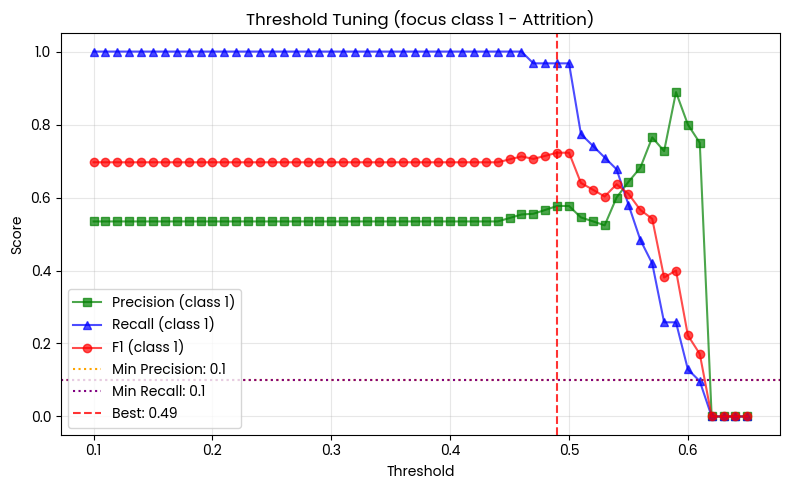


Classification Report (Threshold: 0.49):
              precision    recall  f1-score   support

           0       0.83      0.19      0.30        27
           1       0.58      0.97      0.72        31

    accuracy                           0.60        58
   macro avg       0.71      0.58      0.51        58
weighted avg       0.70      0.60      0.53        58


=== Threshold tuning for KNN ===
Best threshold for f1 class 1: 0.10
F1 score class 1: 0.6966


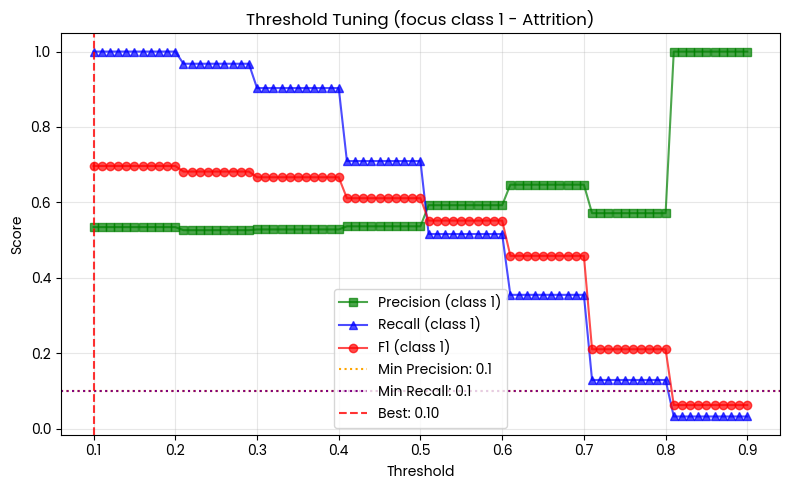


Classification Report (Threshold: 0.10):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.53      1.00      0.70        31

    accuracy                           0.53        58
   macro avg       0.27      0.50      0.35        58
weighted avg       0.29      0.53      0.37        58


=== Threshold tuning for SGDClassifier ===
Best threshold for f1 class 1: 0.24
F1 score class 1: 0.7000


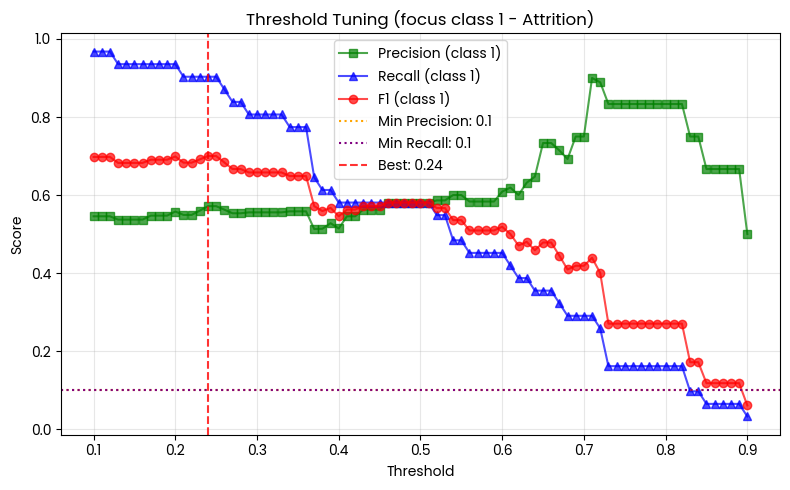


Classification Report (Threshold: 0.24):
              precision    recall  f1-score   support

           0       0.67      0.22      0.33        27
           1       0.57      0.90      0.70        31

    accuracy                           0.59        58
   macro avg       0.62      0.56      0.52        58
weighted avg       0.62      0.59      0.53        58


=== Threshold tuning for MLP ===
Best threshold for f1 class 1: 0.34
F1 score class 1: 0.7105


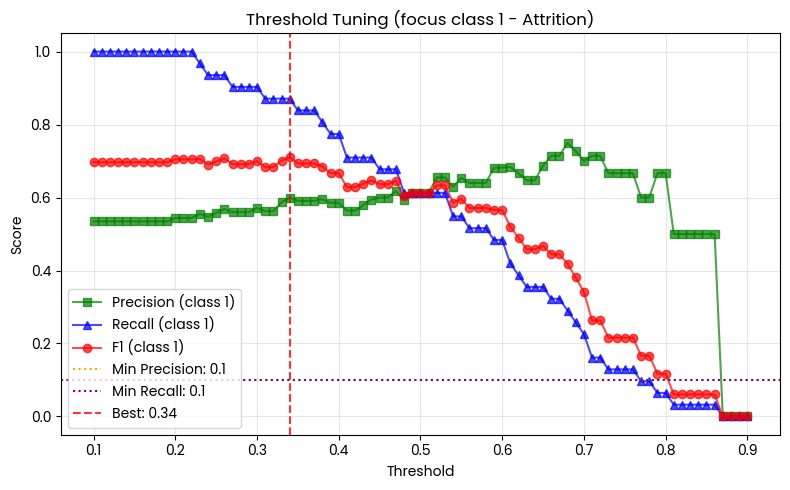


Classification Report (Threshold: 0.34):
              precision    recall  f1-score   support

           0       0.69      0.33      0.45        27
           1       0.60      0.87      0.71        31

    accuracy                           0.62        58
   macro avg       0.65      0.60      0.58        58
weighted avg       0.64      0.62      0.59        58


=== Threshold tuning for RandomForest ===
Best threshold for f1 class 1: 0.10
F1 score class 1: 0.6966


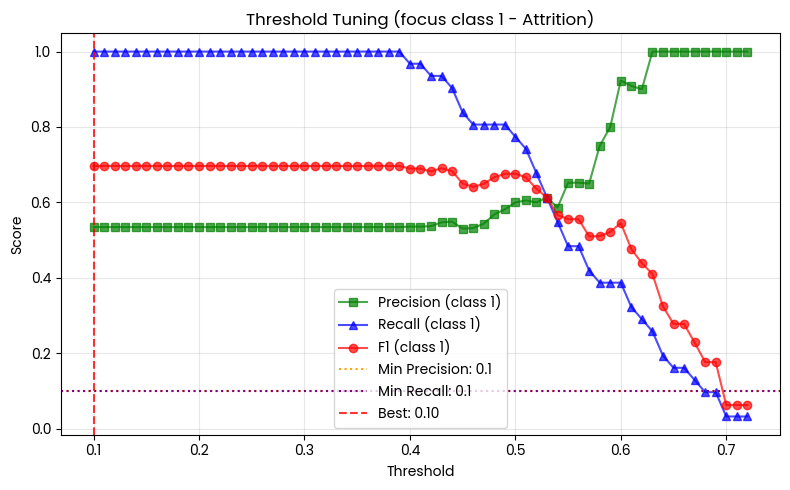


Classification Report (Threshold: 0.10):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.53      1.00      0.70        31

    accuracy                           0.53        58
   macro avg       0.27      0.50      0.35        58
weighted avg       0.29      0.53      0.37        58



,Model,Best_Threshold,Best_F1_Class1,Max_Precision,Max_Recall,Max_F1
0,SVC,0.49,0.722892,0.888889,1.000000,0.722892
1,KNN,0.10,0.696629,1.000000,1.000000,0.696629
2,SGDClassifier,0.24,0.700000,0.900000,0.967742,0.700000
3,MLP,0.34,0.710526,0.750000,1.000000,0.710526
4,RandomForest,0.10,0.696629,1.000000,1.000000,0.696629


In [16]:
def tune_threshold_attrition(pipeline, X_train, y_train, X_test, y_test,
                             metric="f1", min_precision=0.1, min_recall=0.1,
                             verbose=True):
    pipeline.fit(X_train, y_train)

    if hasattr(pipeline, "predict_proba"):
        y_prob = pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(pipeline, "decision_function"):
        y_decision = pipeline.decision_function(X_test)
        y_prob = (y_decision - y_decision.min()) / (y_decision.max() - y_decision.min())
    else:
        raise AttributeError("Model tidak punya predict_proba atau decision_function")

    thresholds = np.linspace(0.1, 0.9, 81)
    results = {'thresholds': [], 'precisions': [], 'recalls': [], 'f1s': []}
    valid_thresholds, valid_scores = [], []

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        if y_pred.sum() == 0:
            continue

        precisions, recalls, f1s, _ = precision_recall_fscore_support(
            y_test, y_pred, average=None, zero_division=0
        )
        precision_1, recall_1, f1_1 = precisions[1], recalls[1], f1s[1]

        results['thresholds'].append(t)
        results['precisions'].append(precision_1)
        results['recalls'].append(recall_1)
        results['f1s'].append(f1_1)

        score = f1_1 if metric == "f1" else precision_1 if metric == "precision" else recall_1
        if precision_1 >= min_precision and recall_1 >= min_recall:
            valid_thresholds.append(t)
            valid_scores.append(score)

    if len(valid_thresholds) == 0:
        print(f"WARNING: no threshold meets precision >= {min_precision} and recall >= {min_recall}")
        scores = results['f1s'] if metric == "f1" else results['precisions'] if metric == "precision" else results['recalls']
        best_idx = np.argmax(scores)
        best_threshold = results['thresholds'][best_idx]
        best_score = scores[best_idx]
    else:
        best_idx = np.argmax(valid_scores)
        best_threshold = valid_thresholds[best_idx]
        best_score = valid_scores[best_idx]
        if verbose:
            print(f"Best threshold for {metric} class 1: {best_threshold:.2f}")
            print(f"{metric.upper()} score class 1: {best_score:.4f}")

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(results['thresholds'], results['precisions'], 'g-', marker='s', label='Precision (class 1)', alpha=0.7)
    ax.plot(results['thresholds'], results['recalls'], 'b-', marker='^', label='Recall (class 1)', alpha=0.7)
    ax.plot(results['thresholds'], results['f1s'], 'r-', marker='o', label='F1 (class 1)', alpha=0.7)
    ax.axhline(min_precision, color='orange', linestyle=':', label=f'Min Precision: {min_precision}')
    ax.axhline(min_recall, color='purple', linestyle=':', label=f'Min Recall: {min_recall}')
    ax.axvline(best_threshold, color='r', linestyle='--', alpha=0.8, label=f'Best: {best_threshold:.2f}')
    ax.set_title('Threshold Tuning (focus class 1 - Attrition)')
    ax.set_xlabel('Threshold'); ax.set_ylabel('Score')
    ax.legend(); ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    if verbose:
        y_pred_best = (y_prob >= best_threshold).astype(int)
        print(f"\nClassification Report (Threshold: {best_threshold:.2f}):")
        print(classification_report(y_test, y_pred_best, zero_division=0))

    return best_threshold, best_score, results

model_mapping = {
    "SVC": SVC,
    "KNN": KNeighborsClassifier,
    "SGDClassifier": SGDClassifier,
    "MLP": MLPClassifier,
    "RandomForest": RandomForestClassifier
}

final_models = {}
for model_name, model_class in model_mapping.items():
    params = optuna_results[optuna_results["Model"] == model_name]["Best Params"].values[0]

    if model_name == "SVC":
        params = {**params, "probability": True}

    if "random_state" in model_class().get_params():
        model = model_class(**params, random_state=42)
    else:
        model = model_class(**params)

    features = selected_features_map[model_name]
    final_models[model_name] = (model, features, X_train[features], X_test[features])

summary_thresholds = []

for model_name, (model, features, X_train_sel, X_test_sel) in final_models.items():
    print(f"\n=== Threshold tuning for {model_name} ===")
    pipeline = rebuild_pipeline(model, features, categorical_features, numeric_features)
    best_threshold, best_score, results = tune_threshold_attrition(
        pipeline=pipeline,
        X_train=X_train_sel,
        y_train=y_train,
        X_test=X_test_sel,
        y_test=y_test,
        metric="f1",
        min_precision=0.1,
        min_recall=0.1,
        verbose=True
    )
    summary_thresholds.append({
        "Model": model_name,
        "Best_Threshold": best_threshold,
        "Best_F1_Class1": best_score,
        "Max_Precision": max(results["precisions"]),
        "Max_Recall": max(results["recalls"]),
        "Max_F1": max(results["f1s"])
    })

threshold_summary_df = pd.DataFrame(summary_thresholds)
display(threshold_summary_df)

## **Evaluation**


=== COMPREHENSIVE EVALUATION: SVC ===
Threshold used: 0.490

1. CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.83      0.19      0.30        27
           1       0.58      0.97      0.72        31

    accuracy                           0.60        58
   macro avg       0.71      0.58      0.51        58
weighted avg       0.70      0.60      0.53        58


2. CONFUSION MATRIX:
[[ 5 22]
 [ 1 30]]



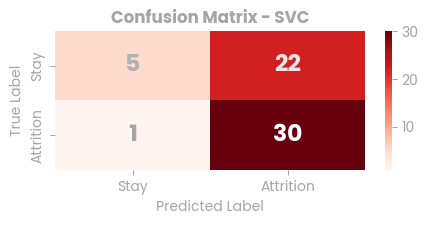

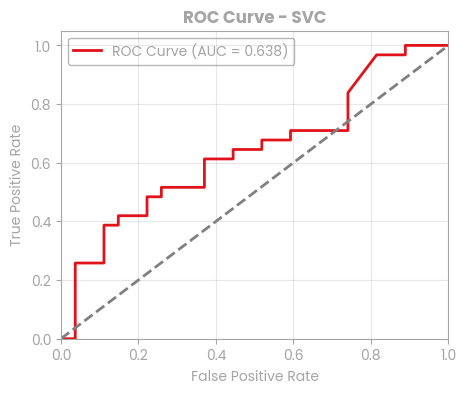

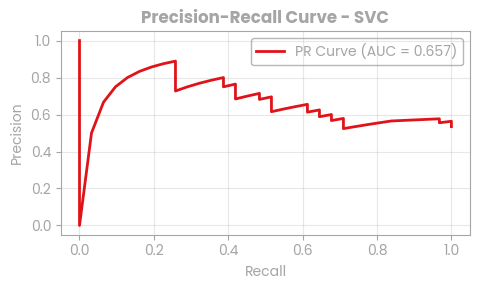


=== COMPREHENSIVE EVALUATION: KNN ===
Threshold used: 0.100

1. CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.53      1.00      0.70        31

    accuracy                           0.53        58
   macro avg       0.27      0.50      0.35        58
weighted avg       0.29      0.53      0.37        58


2. CONFUSION MATRIX:
[[ 0 27]
 [ 0 31]]



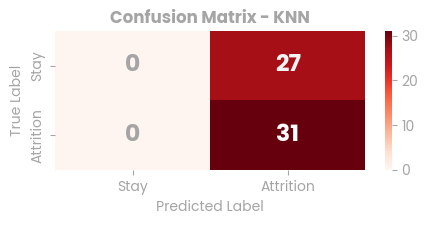

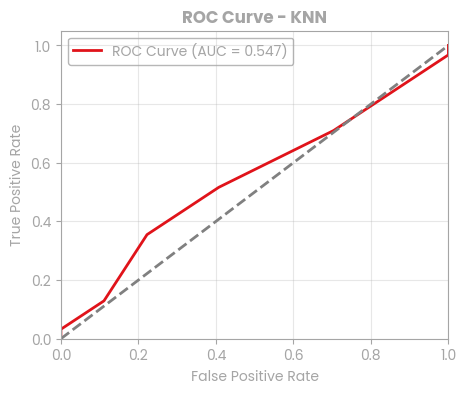

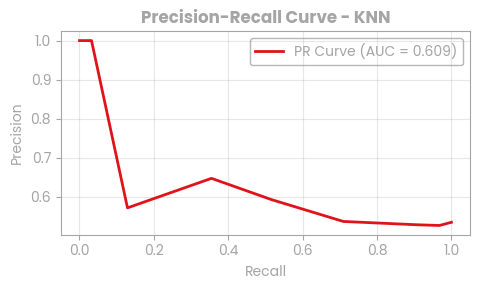


=== COMPREHENSIVE EVALUATION: SGDClassifier ===
Threshold used: 0.240

1. CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.67      0.22      0.33        27
           1       0.57      0.90      0.70        31

    accuracy                           0.59        58
   macro avg       0.62      0.56      0.52        58
weighted avg       0.62      0.59      0.53        58


2. CONFUSION MATRIX:
[[ 6 21]
 [ 3 28]]



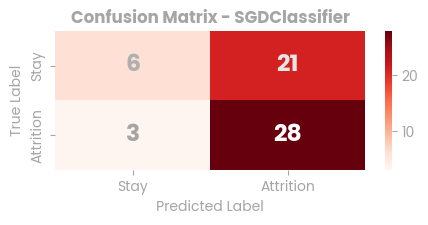

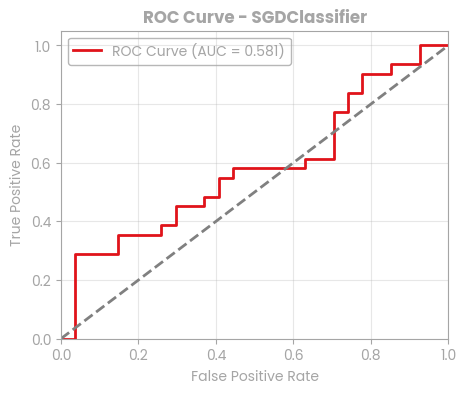

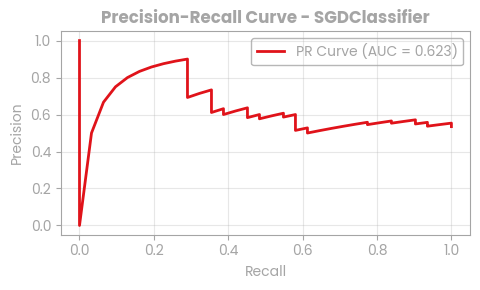


=== COMPREHENSIVE EVALUATION: MLP ===
Threshold used: 0.340

1. CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.69      0.33      0.45        27
           1       0.60      0.87      0.71        31

    accuracy                           0.62        58
   macro avg       0.65      0.60      0.58        58
weighted avg       0.64      0.62      0.59        58


2. CONFUSION MATRIX:
[[ 9 18]
 [ 4 27]]



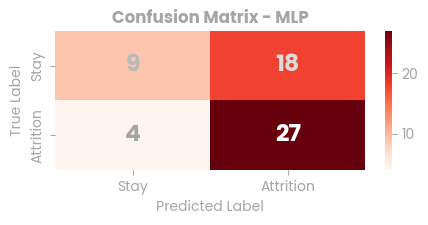

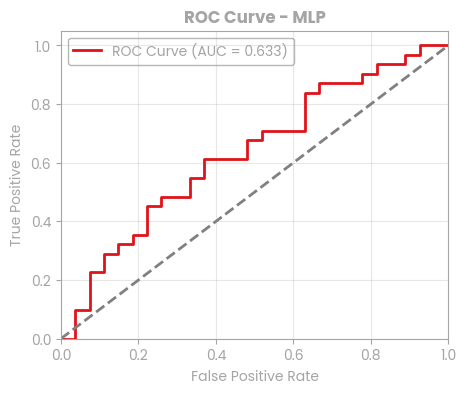

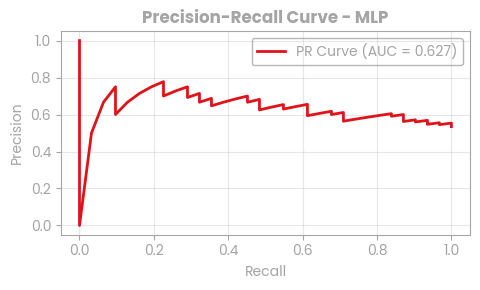


=== COMPREHENSIVE EVALUATION: RandomForest ===
Threshold used: 0.100

1. CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.53      1.00      0.70        31

    accuracy                           0.53        58
   macro avg       0.27      0.50      0.35        58
weighted avg       0.29      0.53      0.37        58


2. CONFUSION MATRIX:
[[ 0 27]
 [ 0 31]]



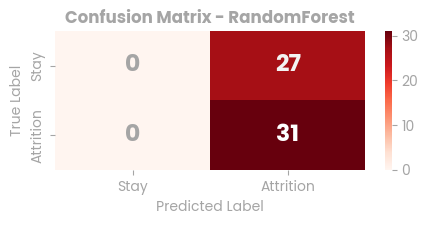

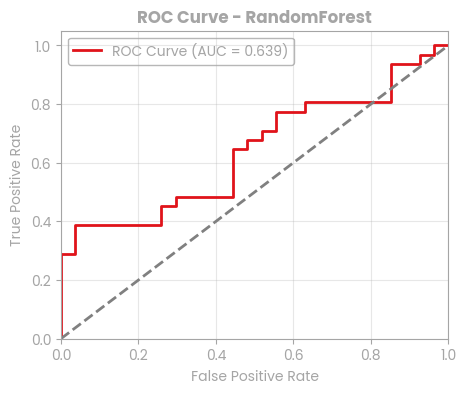

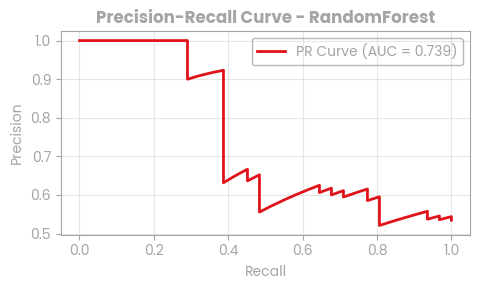

In [19]:
def evaluate_model_with_threshold(pipeline, X_train, y_train, X_test, y_test, best_threshold, model_name="Model"):
    pipeline.fit(X_train, y_train)

    if hasattr(pipeline, "predict_proba"):
        y_scores = pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(pipeline, "decision_function"):
        y_scores = pipeline.decision_function(X_test)
        y_scores = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-9)
    else:
        raise AttributeError(f"Model {model_name} tidak punya predict_proba atau decision_function.")

    y_pred = (y_scores >= best_threshold).astype(int)

    print(f"\n=== COMPREHENSIVE EVALUATION: {model_name} ===")
    print(f"Threshold used: {best_threshold:.3f}\n")

    # Classification Report
    print("1. CLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("2. CONFUSION MATRIX:")
    print(cm)
    print()

    plt.figure(figsize=(5,1.8))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                     annot_kws={"weight": "bold", "fontsize":17},
                     xticklabels=['Stay', 'Attrition'],
                     yticklabels=['Stay', 'Attrition'])
    plt.title(f'Confusion Matrix - {model_name}', fontweight='bold', color='#a5a5a5')
    plt.ylabel('True Label', color='#a5a5a5')
    plt.xlabel('Predicted Label', color='#a5a5a5')

    # Style axis & colorbar
    ax.tick_params(axis='x', colors='#a5a5a5')
    ax.tick_params(axis='y', colors='#a5a5a5')
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(colors='#a5a5a5')

    max_val = np.max(cm)
    min_val = np.min(cm)
    for text in ax.texts:
        val = int(text.get_text())
        alpha = (val - min_val) / (max_val - min_val + 1e-9)
        base_gray = 0.647
        color_val = base_gray + (1 - base_gray) * alpha
        text.set_color((color_val, color_val, color_val))
        text.set_fontweight('bold')

    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, color='#e0131a', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='#808080', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', color='#a5a5a5')
    plt.ylabel('True Positive Rate', color='#a5a5a5')
    plt.title(f'ROC Curve - {model_name}', fontweight='bold', color='#a5a5a5')

    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_color('#a5a5a5')

    plt.tick_params(axis='x', colors='#a5a5a5')
    plt.tick_params(axis='y', colors='#a5a5a5')
    plt.legend(labelcolor='#a5a5a5', facecolor='none', edgecolor='#a5a5a5')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(4.9,3))
    plt.plot(recall, precision, color='#e0131a', lw=2,
             label=f'PR Curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall', color='#a5a5a5')
    plt.ylabel('Precision', color='#a5a5a5')
    plt.title(f'Precision-Recall Curve - {model_name}', fontweight='bold', color='#a5a5a5')
    plt.legend(labelcolor='#a5a5a5', facecolor='none', edgecolor='#a5a5a5')
    plt.grid(True, alpha=0.3)

    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_color('#a5a5a5')

    plt.tick_params(axis='x', colors='#a5a5a5')
    plt.tick_params(axis='y', colors='#a5a5a5')
    plt.tight_layout()
    plt.show()


# Evaluate all models
for model_name, (model, features, X_train_sel, X_test_sel) in final_models.items():
    best_threshold = threshold_summary_df.loc[
        threshold_summary_df["Model"] == model_name, "Best_Threshold"
    ].values[0]

    pipeline = rebuild_pipeline(model, features, categorical_features, numeric_features)

    evaluate_model_with_threshold(
        pipeline=pipeline,
        X_train=X_train_sel,
        y_train=y_train,
        X_test=X_test_sel,
        y_test=y_test,
        best_threshold=best_threshold,
        model_name=model_name
    )

## **Feature Importance**


Computing feature importance for SVC ...


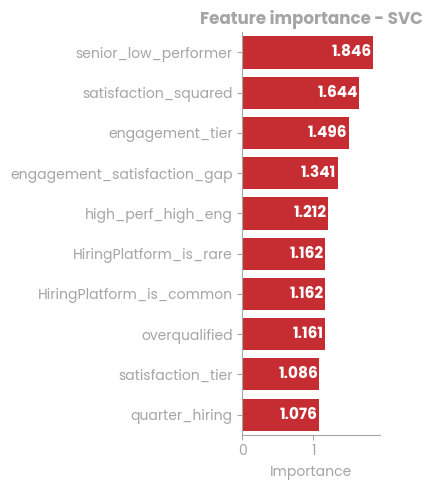


Computing feature importance for KNN ...


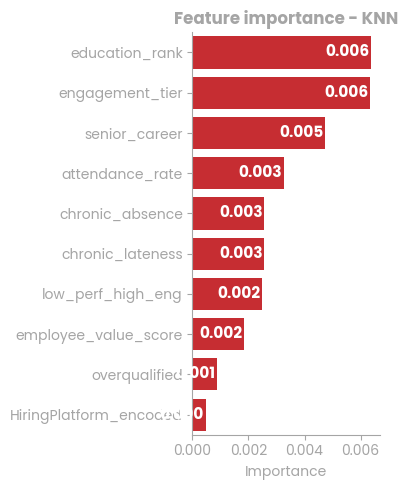


Computing feature importance for SGDClassifier ...


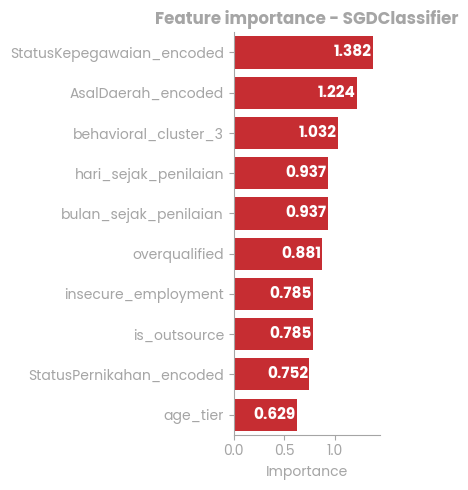


Computing feature importance for MLP ...


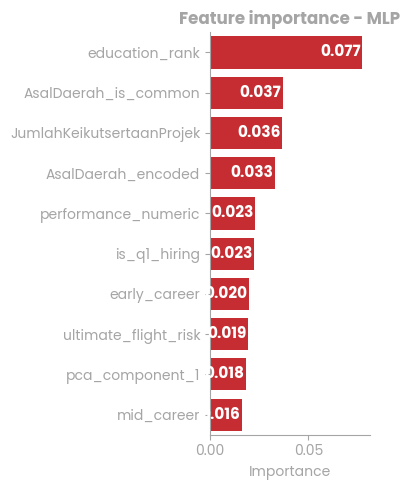


Computing feature importance for RandomForest ...


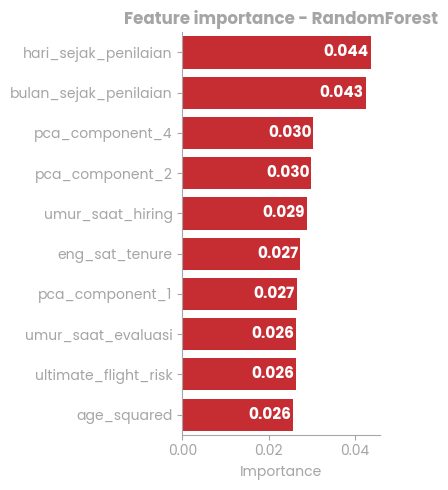

,feature,importance,method,Model,importance_std
104,education_rank,0.006376,permutation_30rep,KNN,0.001633
105,engagement_tier,0.006333,permutation_30rep,KNN,0.001606
106,senior_career,0.004745,permutation_30rep,KNN,0.014501
107,attendance_rate,0.003259,permutation_30rep,KNN,0.005290
108,chronic_absence,0.002568,permutation_30rep,KNN,0.003286
109,chronic_lateness,0.002568,permutation_30rep,KNN,0.003286
110,low_perf_high_eng,0.002483,permutation_30rep,KNN,0.007825
111,employee_value_score,0.001847,permutation_30rep,KNN,0.000855
112,overqualified,0.000886,permutation_30rep,KNN,0.001650
113,HiringPlatform_encoded,0.000472,permutation_30rep,KNN,0.002171


Saved feature_importances_all_models.csv and per-model PNGs.


In [149]:
importances_list = []

def _get_feature_names_from_pipeline(pipeline, selected_features):
    try:
        preproc = pipeline.named_steps['preprocessor']
    except Exception:
        try:
            preproc = pipeline.steps[[name for name, _ in pipeline.steps].index('preprocessor')][1]
        except Exception:
            return selected_features

    if isinstance(preproc, ColumnTransformer):
        feature_names = []
        for name, transformer, cols in preproc.transformers_:
            if name == 'remainder' and transformer == 'drop':
                continue
            if isinstance(cols, (list, tuple)):
                feature_names.extend(list(cols))
            else:
                return selected_features
        return feature_names
    else:
        # fallback
        return selected_features

def compute_feature_importance_for_model(model, pipeline_builder, selected_features,
                                         X_train_sel, y_train, scoring='roc_auc',
                                         n_repeats=30, random_state=42):
    pipeline = pipeline_builder(model)
    pipeline.fit(X_train_sel, y_train)

    feature_names = _get_feature_names_from_pipeline(pipeline, selected_features)

    clf = pipeline.named_steps.get('classifier', pipeline.steps[-1][1])

    if hasattr(clf, "feature_importances_"):
        imp = clf.feature_importances_
        df = pd.DataFrame({
            "feature": feature_names,
            "importance": imp
        }).sort_values("importance", ascending=False)
        method = "feature_importances_"
    elif hasattr(clf, "coef_"):
        coef = clf.coef_
        if coef.ndim == 1:
            abscoef = np.abs(coef)
        else:
            abscoef = np.mean(np.abs(coef), axis=0)
        df = pd.DataFrame({
            "feature": feature_names,
            "importance": abscoef
        }).sort_values("importance", ascending=False)
        method = "coef_"
    else:
        r = permutation_importance(pipeline, X_train_sel, y_train,
                                   n_repeats=n_repeats, random_state=random_state,
                                   scoring=scoring, n_jobs=-1)
        imp_mean = r.importances_mean
        imp_std = r.importances_std
        df = pd.DataFrame({
            "feature": feature_names,
            "importance": imp_mean,
            "importance_std": imp_std
        }).sort_values("importance", ascending=False)
        method = f"permutation_{n_repeats}rep"
    df['method'] = method
    return df, pipeline

def plot_feature_importance(importance_df, title="Feature importance", top_n=10, save_as=None):
    """
    importance_df: DataFrame with columns ['feature','importance'] (and optionally importance_std)
    akan plot horizontal barplot menggunakan style yang kamu pakai.
    """
    df = importance_df.copy()
    df = df.sort_values("importance", ascending=False).head(top_n)
    plt.figure(figsize=(4,5))
    ax = sns.barplot(x="importance", y="feature", data=df, color='#e0131a')
    plt.title(title, fontweight='bold', color='#a5a5a5')
    plt.xlabel("Importance", color='#a5a5a5')
    plt.ylabel("", color='#a5a5a5')

    for spine in ax.spines.values():
        spine.set_color('#a5a5a5')

    plt.tick_params(axis='x', colors='#a5a5a5')
    plt.tick_params(axis='y', colors='#a5a5a5')

    max_imp = df["importance"].max() if not df["importance"].empty else 1.0
    for p in ax.patches:
        value = p.get_width()
        ax.text(
            value - (0.01 * max_imp),
            p.get_y() + p.get_height()/2,
            f"{value:.3f}", fontsize=11,
            ha="right", va="center",
            color="white", fontweight="bold"
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    if save_as:
        plt.savefig(save_as, transparent=True, dpi=750)
    plt.show()

all_importances = []

for model_name, (model, features, X_train_sel, X_test_sel) in final_models.items():
    pipeline_builder = lambda m: rebuild_pipeline(m, features, categorical_features, numeric_features, apply_smote=False)
    imp_df, fitted_pipeline = compute_feature_importance_for_model(model, pipeline_builder, features, X_train_sel, y_train,
                                                                   scoring='roc_auc', n_repeats=30, random_state=42)
    imp_df['Model'] = model_name
    all_importances.append(imp_df)

    title = f"Feature importance - {model_name}"
    savefile = f"feature-imp-{model_name.lower()}.png"
    plot_feature_importance(imp_df, title=title, top_n=10, save_as=savefile)

importance_all_df = pd.concat(all_importances, ignore_index=True)
display(importance_all_df.sort_values(['Model','importance'], ascending=[True, False]).head(30))


Computing SHAP global importance for SVC ...


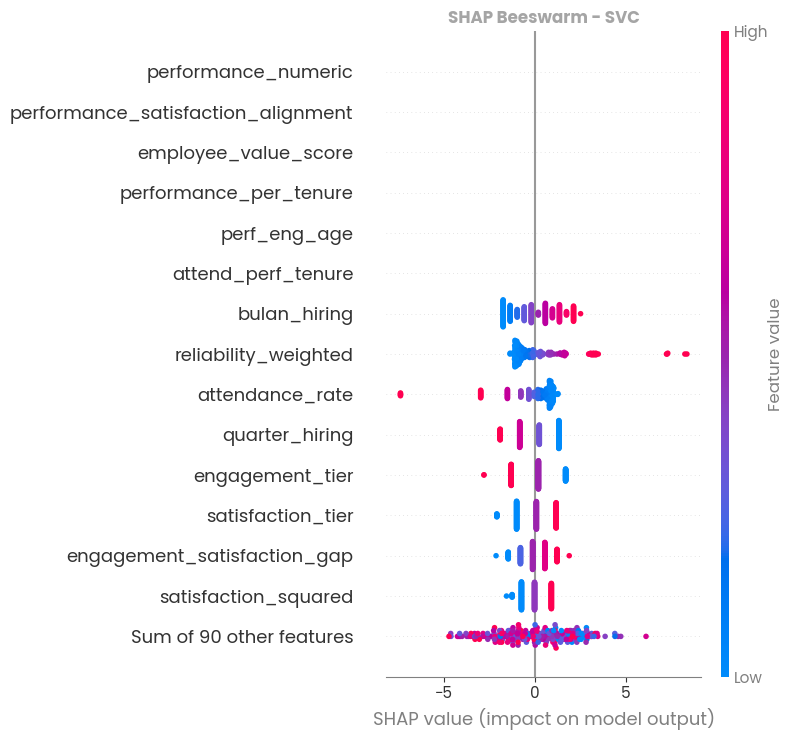


Computing SHAP global importance for KNN ...
Falling back to KernelExplainer for KNN (The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsClassifier(metric='euclidean', n_neighbors=10))


  0%|          | 0/229 [00:00<?, ?it/s]

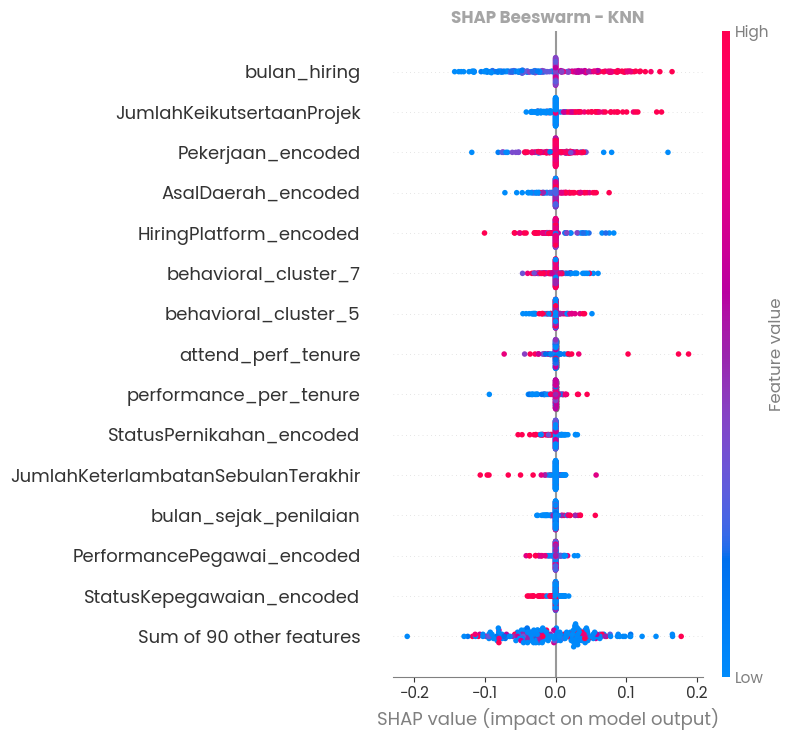


Computing SHAP global importance for SGDClassifier ...


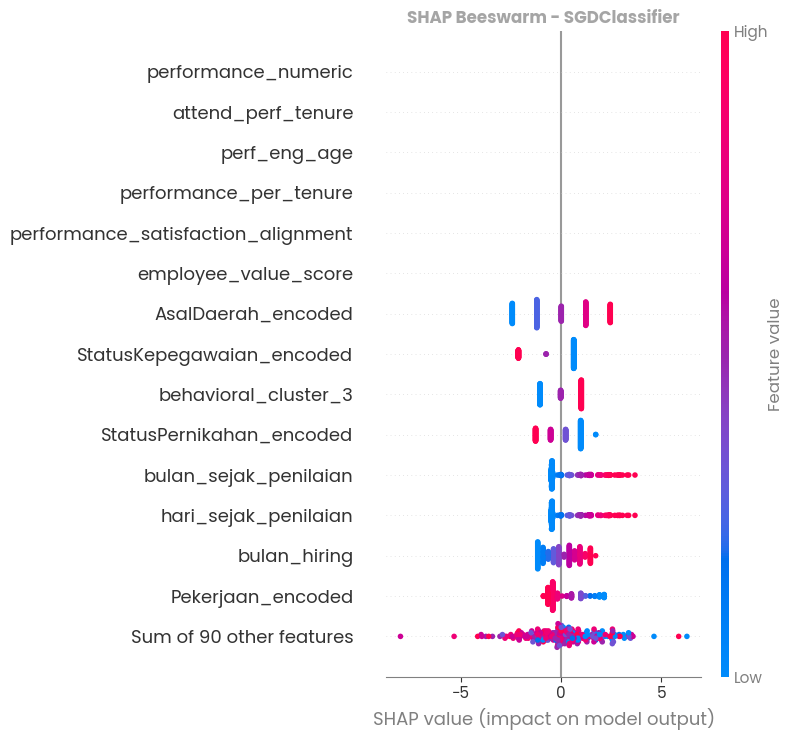


Computing SHAP global importance for MLP ...
Falling back to KernelExplainer for MLP (The passed model is not callable and cannot be analyzed directly with the given masker! Model: MLPClassifier(alpha=0.003907777537012372, hidden_layer_sizes=(18, 31),
              learning_rate_init=0.0002418601616595225, random_state=42))


  0%|          | 0/229 [00:00<?, ?it/s]

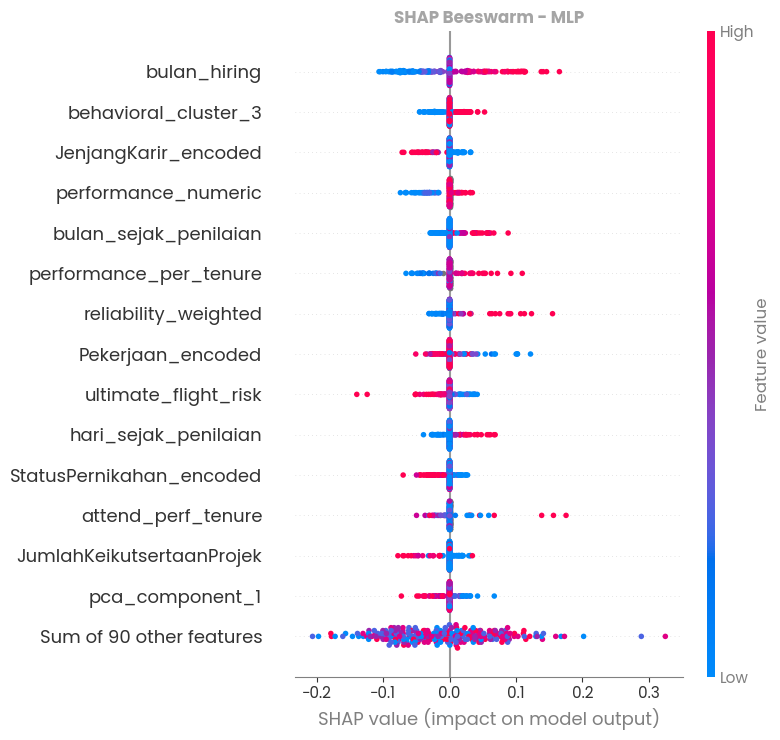


Computing SHAP global importance for RandomForest ...
RandomForest: Detected multi-class array, using class 1


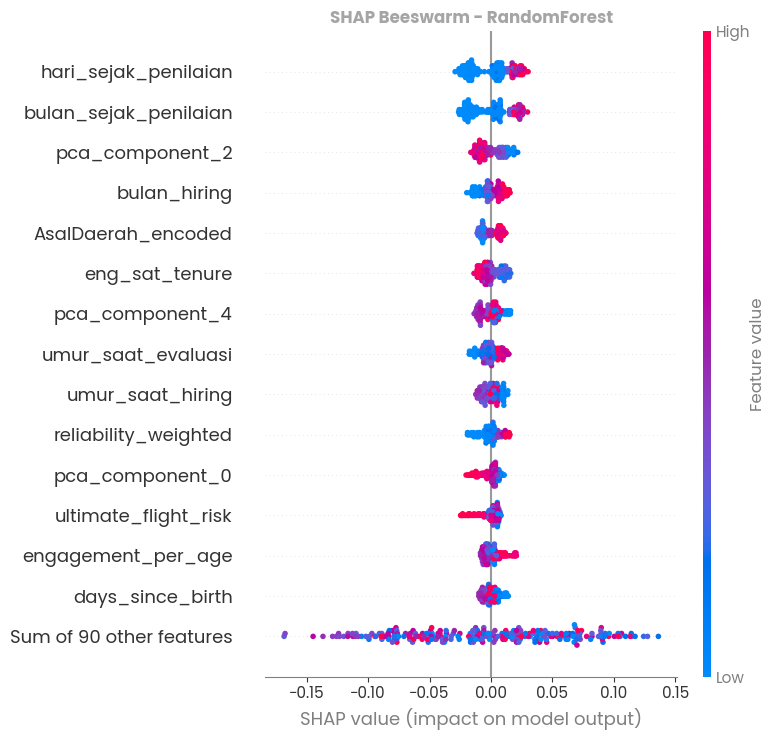

In [155]:
import shap

def compute_shap_global(pipeline, X_train_sel, model_name, max_display=15, save_prefix="shap"):
    preproc = pipeline.named_steps['preprocessor']
    X_transformed = preproc.transform(X_train_sel)
    feature_names = _get_feature_names_from_pipeline(pipeline, X_train_sel.columns.tolist())

    clf = pipeline.named_steps['classifier']

    try:
        explainer = shap.Explainer(clf, X_transformed, feature_names=feature_names)
        shap_values = explainer(X_transformed)
    except Exception as e:
        print(f"Falling back to KernelExplainer for {model_name} ({e})")
        f = lambda x: pipeline.predict_proba(pd.DataFrame(x, columns=X_train_sel.columns))[:, 1]
        background = shap.sample(X_train_sel, 100, random_state=42)
        explainer = shap.KernelExplainer(f, background)
        shap_vals = explainer.shap_values(X_train_sel, nsamples=200)

        if isinstance(shap_vals, list):
            shap_vals = shap_vals[1]

        shap_values = shap.Explanation(
            values=shap_vals,
            base_values=explainer.expected_value if isinstance(explainer.expected_value, float) else explainer.expected_value[1],
            data=X_train_sel.values,
            feature_names=X_train_sel.columns
        )

    values_to_plot = shap_values
    if isinstance(shap_values, list):
        print(f"{model_name}: Detected multi-class list, using class 1")
        values_to_plot = shap_values[1]
    elif hasattr(shap_values, "values") and shap_values.values.ndim == 3:
        print(f"{model_name}: Detected multi-class array, using class 1")
        values_to_plot = shap_values[:, :, 1]

    plt.title(f"SHAP Beeswarm - {model_name}", fontweight='bold', color='#a5a5a5')
    shap.plots.beeswarm(values_to_plot, max_display=max_display, show=False)
    plt.tight_layout()
    plt.show()

    return shap_values

shap_results = {}

for model_name, (model, features, X_train_sel, X_test_sel) in final_models.items():
    print(f"\nComputing SHAP global importance for {model_name} ...")
    pipeline = rebuild_pipeline(model, features, categorical_features, numeric_features, apply_smote=False)
    pipeline.fit(X_train_sel, y_train)

    shap_values = compute_shap_global(pipeline, X_train_sel, model_name, max_display=15, save_prefix="shap")
    shap_results[model_name] = shap_values